In [ ]:
# default_exp multiscale_flow_embedder
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import directed_graphs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2
device

# 05c Multiscale Flow Embeddings with a Grid
The problem with the Diffusion Flow Embedder (05b) is that, although it minimizes the loss quite well, achieving 0 cost only requires the network to replicate the graph's *affinity* matrix within the embedding. Consequently, the embedding only preserves near neighbors; like tSNE, it willfully distorts global structure.

This manifests in, for example 05b05 and 05b05a, where we see that the spiral (and the swiss roll) are not *unrolled*, as we'd like -- but are either left coiled, as in their projections, or wrapped oddly. The affinity matrices of the embeddings are beautiful. They have no way of telling how weird the global structure is. 

As a result, the flows learnt by the method are unnecessarily complex, and tend to wrap around the manifold. The flows are only used for near neighbor connectivity, hence there is no incentive to learn anything that makes sense in long ranges.

This notebook is motivated by a suspicion that these effects can be greatly lessened with two novel additions:
1. *multiscale* diffusion probability comparisons  -- between $P_{graph}^t$ and $P_{embedding}^t$ for several values of $t$, but only in which
2. a *grid* connects points in the embedding space in a way the ambient points aren't connected.

Much of the machinery for this was already developed in 05b. We need only introduce the grid, and a multiscale loss.

I'm additionally going to try to make the class as *modular* as possible, to avoid the syndrome of doing everything within one giant code block with a class that has dozens of functions.

In [ ]:
# export
from directed_graphs.diffusion_flow_embedding import (
    affinity_matrix_from_pointset_to_pointset,
    smoothness_of_vector_field,
)


def compute_grid(X, grid_width=20):
    """Returns a grid of points which bounds the points X.
    The grid has 'grid_width' dots in both length and width.
    Accepts X, tensor of shape n x 2
    Returns tensor of shape grid_width^2 x 2"""
    # TODO: This currently only supports
    # find support of points
    minx = float(torch.min(X[:, 0]) - 0.1)  # TODO: use torch.min, try without detach
    maxx = float(torch.max(X[:, 0]) + 0.1)
    miny = float(torch.min(X[:, 1]) - 0.1)
    maxy = float(torch.max(X[:, 1]) + 0.1)
    # form grid around points
    x, y = torch.meshgrid(
        torch.linspace(minx, maxx, steps=grid_width),
        torch.linspace(miny, maxy, steps=grid_width),
        indexing="ij",
    )
    xy_t = torch.concat([x[:, :, None], y[:, :, None]], dim=2).float()
    xy_t = xy_t.reshape(grid_width**2, 2).detach()
    return xy_t

A cornerstone of this method will be the powering of the diffusion matrix, which must intersperse jumping between points in the dataset and in the surrounding grid. Traditional matrix powering will do, provided we add the grid points to the dataset before powering, and then take them out afterwards.

In [ ]:
# export
import torch
from directed_graphs.diffusion_flow_embedding import (
    affinity_matrix_from_pointset_to_pointset,
    GaussianVectorField,
)
import torch.nn.functional as F


def diffusion_matrix_with_grid_points(X, grid, flow_function, t, sigma, flow_strength):
    n_points = X.shape[0]
    # combine the points and the grid
    points_and_grid = torch.concat([X, grid], dim=0)
    # get flows at each point
    flow_per_point = flow_function(points_and_grid)
    # take a diffusion matrix
    A = affinity_matrix_from_pointset_to_pointset(
        points_and_grid,
        points_and_grid,
        flows=flow_per_point,
        sigma=sigma,
        flow_strength=flow_strength,
    )
    P = F.normalize(A, p=1, dim=-1)
    # TODO: Should we remove self affinities? Probably not, as lazy random walks are advantageous when powering
    # Power the matrix to t steps
    Pt = torch.matrix_power(P, t)
    # Recover the transition probabilities between the points, and renormalize them
    Pt_points = Pt[:n_points, :n_points]
    # Pt_points = torch.diag(1/Pt_points.sum(1)) @ Pt_points
    Pt_points = F.normalize(Pt_points, p=1, dim=1)
    # return diffusion probs between points
    return Pt_points

In [ ]:
A = torch.tensor([[1, 2], [3, 4], [5, 6]])
B = torch.rand(5, 2)
K = GaussianVectorField(2, 25, device=torch.device("cpu"))
out = diffusion_matrix_with_grid_points(A, B, K, 1, 0.5, 4)
out

tensor([[9.9995e-01, 4.7606e-05, 1.6631e-07],
        [2.2208e-03, 9.9237e-01, 5.4120e-03],
        [1.2162e-05, 3.4813e-03, 9.9651e-01]], grad_fn=<DivBackward0>)

## General embedding matrix
The architecture should support modular swapping of point embedding methods. A few of these include:
1. Feedforward embedder (paired with a decoder)
2. Learnable initialized points (random, or to a prior embedding initialization, like DMaps, UMAP, PHATE...)
3. Fixed initializations, if we want the flow to contort itself to the initialization
This will take the shape of swappable "embedder" classes, which can be supplied as input to the network.

For example, here is the simple FF net we use in the autoencoder:

In [ ]:
# export
import torch.nn as nn
from collections import OrderedDict


class FeedForwardReLU(nn.Module):
    def __init__(self, shape):
        super(FeedForwardReLU, self).__init__()
        d_len = len(shape) * 2
        d = OrderedDict()
        d[str(0)] = nn.Linear(shape[0], shape[1])
        for i in range(1, d_len - 3):
            if i % 2 == 1:
                d[str(i)] = nn.LeakyReLU()
            else:
                d[str(i)] = nn.Linear(shape[int(i / 2)], shape[int(i / 2) + 1])
        # create MLP
        self.FA = nn.Sequential(d)

    def forward(self, X):
        return self.FA(X)

In [ ]:
fa = FeedForwardReLU(shape=[2, 3, 4, 5, 6, 5, 4, 3, 2])
fa

FeedForwardReLU(
  (FA): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=3, out_features=4, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=4, out_features=5, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=5, out_features=6, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=6, out_features=5, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=5, out_features=4, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=4, out_features=3, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Linear(in_features=3, out_features=2, bias=True)
  )
)

In [ ]:
%%javascript

IPython.tab_as_tab_everywhere = function(use_tabs) {
    if (use_tabs === undefined) {
        use_tabs = true; 
    }

    // apply setting to all current CodeMirror instances
    IPython.notebook.get_cells().map(
        function(c) {  return c.code_mirror.options.indentWithTabs=use_tabs;  }
    );
    // make sure new CodeMirror instances created in the future also use this setting
    CodeMirror.defaults.indentWithTabs=use_tabs;

    };

IPython.tab_as_tab_everywhere()

<IPython.core.display.Javascript object>

# The Flow Embedder

In [ ]:
# export
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
from directed_graphs.diffusion_flow_embedding import (
    GaussianVectorField,
    smoothness_of_vector_field,
    FlowArtist,
)
from directed_graphs.diffusion_flow_embedding import (
    diffusion_map_loss,
    flow_cosine_loss,
    directed_neighbors,
    flow_neighbor_loss,
    precomputed_distance_loss,
)
from directed_graphs.utils import diffusion_map_from_points


class MultiscaleDiffusionFlowEmbedder(torch.nn.Module):
    def __init__(
        self,
        X,
        flows,
        ts=(1, 2, 4, 8),
        sigma_graph=0.5,
        sigma_embedding=0.5,
        flow_strength_graph=5,
        flow_strength_embedding=5,
        n_neighbors=20,
        embedding_dimension=2,
        learning_rate=1e-3,
        flow_artist="ReLU",
        flow_artist_shape=(2, 4, 8, 4, 2),
        num_flow_gaussians=25,
        embedder=None,
        decoder=None,
        labels=None,
        loss_weights=None,
        use_embedding_grid=False,
        device=torch.device("cpu"),
        k_dmap=20,
        t_dmap=1,
        dmap_coords_to_use=2,
    ):
        super(MultiscaleDiffusionFlowEmbedder, self).__init__()

        # generate default parameters
        embedder = (
            FeedForwardReLU(shape=(3, 4, 8, 4, 2)) if embedder is None else embedder
        )
        loss_keys = [
            "diffusion",
            "smoothness",
            "reconstruction",
            "diffusion map regularization",
            "flow cosine loss",
            "flow neighbor loss",
        ]
        loss_weights = {"diffusion": 1} if loss_weights is None else loss_weights
        for key in loss_keys:
            if key not in loss_weights.keys():
                loss_weights[key] = 0

        # initialize parameters
        self.X = X
        self.ground_truth_flows = flows
        self.ts = ts
        self.sigma_embedding = sigma_embedding
        self.sigma_graph = sigma_graph
        self.nnodes = X.shape[0]
        self.data_dimension = X.shape[1]
        self.use_embedding_grid = use_embedding_grid

        self.eps = 0.001
        self.loss_weights = loss_weights
        self.labels = labels
        self.flow_strength = torch.tensor(flow_strength_embedding).float()
        self.embedding_dimension = embedding_dimension
        # set device (used for shuffling points around during visualization)
        self.device = device
        # Used for
        self.losses = {}
        for k in self.loss_weights.keys():
            self.losses[k] = []

        self.P_graph = affinity_matrix_from_pointset_to_pointset(
            X, X, flows, sigma=sigma_graph, flow_strength=flow_strength_graph
        )
        self.P_graph = F.normalize(self.P_graph, p=1, dim=1)
        self.n_neighbors = n_neighbors
        self.neighbors = directed_neighbors(self.nnodes, self.P_graph, self.n_neighbors)
        # torch.diag(1/self.P_graph.sum(axis=1)) @ self.P_graph
        # compute matrix powers
        # TODO: Could reuse previous powers to speed this up
        self.P_graph_ts = [torch.matrix_power(self.P_graph, t) for t in self.ts]
        self.P_embedding_ts = [None for i in self.ts]
        # Flow field
        self.FlowArtist = FlowArtist(
            flow_artist,
            dim=self.embedding_dimension,
            num_gauss=num_flow_gaussians,
            shape=flow_artist_shape,
            device=self.device,
        ).to(self.device)

        # Autoencoder to embed the points into a low dimension
        self.embedder = embedder.to(self.device)
        if decoder is not None:
            self.decoder = decoder.to(self.device)
        else:
            self.decoder = None

        # Precompute graph distances for any loss functions that regularize against a precomputed embedding
        if self.loss_weights["diffusion map regularization"] > 0:
            X_numpy = X.clone().cpu().numpy()
            diff_map = diffusion_map_from_points(
                X_numpy, k=k_dmap, t=t_dmap, plot_evals=True
            )
            self.diff_coords = diff_map[:, :dmap_coords_to_use]
            self.diff_coords = self.diff_coords.real
            # scale to be between 0 and 1 (by default, the diff coords are tiny, which messes up the flow embedder)
            #             self.diff_coords = 2 * (self.diff_coords / np.max(self.diff_coords))
            self.diff_coords = torch.tensor(self.diff_coords.copy()).to(device)
            self.precomputed_distances = torch.cdist(self.diff_coords, self.diff_coords)
            # scale distances between 0 and 1
            self.precomputed_distances = 2 * (
                self.precomputed_distances / torch.max(self.precomputed_distances)
            )
            self.precomputed_distances = (
                self.precomputed_distances.detach()
            )  # no need to have gradients from this operation

        # training ops
        self.KLD = nn.KLDivLoss(reduction="batchmean", log_target=False)
        self.MSE = nn.MSELoss()
        # self.KLD = homemade_KLD # when running on mac
        self.epsilon = 1e-6  # set zeros to eps
        self.optim = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # split input data into batches

    def diffusion_loss(self):
        # compute grid around points
        if self.use_embedding_grid:
            self.grid = compute_grid(self.embedded_points).to(self.device)
        else:
            # take a convex combination of points # TODO: can be much improved
            self.grid = (
                self.embedded_points + torch.flip(self.embedded_points, dims=[0])
            ) / 2
            self.grid = (
                self.grid.detach()
            )  # don't want gradients flowing back through this
        # normalize embedded points to lie within -self.embedding_bounds, self.embedding_bounds
        # if any are trying to escape, constrain them to lie on the edges
        # self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds] = self.embedding_bounds * (self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds])/torch.abs(self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds])
        # self.embedded_points[:,1][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds] = self.embedding_bounds * (self.embedded_points[:,1][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds])/torch.abs(self.embedded_points[:,0][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds])
        # compute embedding diffusion matrix, using including diffusion to grid points
        for i, t in enumerate(self.ts):
            self.P_embedding_ts[i] = diffusion_matrix_with_grid_points(
                X=self.embedded_points,
                grid=self.grid,
                flow_function=self.FlowArtist,
                t=t,
                sigma=self.sigma_embedding,
                flow_strength=self.flow_strength,
            )
            # set any affinities of zero to a very small amount, to prevent the KL divergence from becoming infinite.
            self.P_embedding_ts[i][
                self.P_embedding_ts[i] == 0
            ] = (
                self.epsilon
            )  # TODO: Perhaps enable later; this didn't cause NaN errors before
            # self.P_embedding_ts[i] = self.P_embedding_ts[i] + self.epsilon
        # take KL divergence between P embedding ts and P graph ts
        diffusion_loss = 0
        """
        for i in range(len(self.ts)):
            log_P_embedding_t = torch.log(self.P_embedding_ts[i])
            log_P_graph_t = torch.log(self.P_graph_ts[i])            
            if log_P_embedding_t.is_sparse:
                KL_emb = log_P_embedding_t.to_dense()
                KL_graph = log_P_graph_t.to_dense()
                diffusion_loss_for_t = 0.5*(self.KLD(KL_emb, KL_graph) + self.KLD(KL_graph, KL_emb))
            else:
                A = log_P_embedding_t
                B = log_P_graph_t
                diffusion_loss_for_t = 0.5*(self.KLD(A,B) + self.KLD(B,A))
            diffusion_loss += (2**(-i))*diffusion_loss_for_t
            # print(f"Diffusion loss {i} is {diffusion_loss}")
        """
        for i in range(len(self.ts)):
            log_P_embedding_t = torch.log(self.P_embedding_ts[i])
            if log_P_embedding_t.is_sparse:
                diffusion_loss_for_t = self.KLD(
                    log_P_embedding_t.to_dense(), self.P_graph_ts[i].to_dense()
                )
            else:
                diffusion_loss_for_t = self.KLD(log_P_embedding_t, self.P_graph_ts[i])
            diffusion_loss += (2 ** (-i)) * diffusion_loss_for_t
            # print(f"Diffusion loss {i} is {diffusion_loss}")
        self.losses["diffusion"].append(diffusion_loss)
        if diffusion_loss.isnan():
            raise NotImplementedError
        return diffusion_loss

    def loss(self):
        # embed points
        self.embedded_points = self.embedder(self.X)
        # compute diffusion loss on embedded points
        if self.loss_weights["diffusion"] != 0:
            diffusion_loss = self.diffusion_loss()
        else:
            diffusion_loss = 0
        # compute autoencoder loss
        if self.decoder is not None:
            X_reconstructed = self.decoder(self.embedded_points)
            reconstruction_loss = self.MSE(X_reconstructed, self.X)
            self.losses["reconstruction"].append(reconstruction_loss)
        else:
            reconstruction_loss = 0
        # regularizations
        if self.loss_weights["smoothness"] != 0:
            smoothness_loss = smoothness_of_vector_field(
                self.embedded_points, self.FlowArtist, device=self.device, grid_width=20
            )
            self.losses["smoothness"].append(smoothness_loss)
        else:
            smoothness_loss = 0

        if self.loss_weights["diffusion map regularization"] != 0:
            diffmap_loss = precomputed_distance_loss(
                self.precomputed_distances, self.embedded_points
            )
            #           diffmap_loss = diffusion_map_loss(self.P_graph_ts[0], self.embedded_points)
            self.losses["diffusion map regularization"].append(diffmap_loss)
        else:
            diffmap_loss = 0

        if self.loss_weights["flow cosine loss"] != 0:
            flow_loss = flow_cosine_loss(
                self.X, self.ground_truth_flows, self.FlowArtist(self.embedded_points)
            )
            self.losses["flow cosine loss"].append(flow_loss)
        else:
            flow_loss = 0

        if self.loss_weights["flow neighbor loss"] != 0:
            neighbor_loss = neighbor_loss(
                self.P_graph,
                self.embedded_points,
                self.FlowArtist(self.embedded_points),
            )
            self.losses["flow neighbor loss"].append(neighbor_loss)
        else:
            neighbor_loss = 0

        cost = (
            self.loss_weights["diffusion"] * diffusion_loss
            + self.loss_weights["reconstruction"] * reconstruction_loss
            + self.loss_weights["smoothness"] * smoothness_loss
            + self.loss_weights["diffusion map regularization"] * diffmap_loss
            + self.loss_weights["flow cosine loss"] * flow_loss
            + self.loss_weights["flow neighbor loss"] * neighbor_loss
        )
        return cost

    def visualize_points(self, labels=None):
        # controls the x and y axes of the plot
        # linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
        if labels is None:
            labels = self.labels
        uv = self.FlowArtist(self.grid).detach().cpu()
        u = uv[:, 0].cpu()
        v = uv[:, 1].cpu()
        x = self.grid.detach().cpu()[:, 0]
        y = self.grid.detach().cpu()[:, 1]
        # quiver
        #      plots a 2D field of arrows
        #      quiver([X, Y], U, V, [C], **kw);
        #      X, Y define the arrow locations, U, V define the arrow directions, and C optionally sets the color.
        if labels is not None:
            sc = plt.scatter(
                self.embedded_points[:, 0].detach().cpu(),
                self.embedded_points[:, 1].detach().cpu(),
                c=labels,
            )
            plt.legend()
        else:
            sc = plt.scatter(
                self.embedded_points[:, 0].detach().cpu(),
                self.embedded_points[:, 1].detach().cpu(),
            )
        plt.suptitle("Flow Embedding")
        plt.quiver(x, y, u, v)
        # Display all open figures.
        plt.show()

    def visualize_loss(self, loss_type="total"):
        # diffusion_loss,reconstruction_loss, smoothness_loss
        x = []
        k = ""
        losses = {}
        for key in self.losses.keys():
            losses[key] = []
            k = key
        losses["total"] = []
        for i in range(len(self.losses["diffusion"])):
            x.append(i)
            for key in self.losses.keys():
                try:
                    losses[key].append(self.losses[key][i].detach().cpu().numpy())
                except:
                    losses[key].append(0)
        if loss_type == "all":
            for key in self.losses.keys():
                plt.plot(x, losses[key])
            plt.legend(self.losses.keys(), loc="upper right")
            plt.title("loss")
        else:
            plt.plot(x, losses[loss_type])
            plt.title(loss_type)

    def visualize_diffusion_matrices(self):
        if len(self.ts) >= 3:
            fig, axs = plt.subplots(3, 2, figsize=(10, 15))
            axs[0][0].set_title(f"Ambient $P^{self.ts[0]}$")
            axs[0][0].imshow(self.P_graph_ts[0].detach().cpu().numpy())
            axs[0][1].set_title(f"Embedding $P^{self.ts[0]}$")
            axs[0][1].imshow(self.P_embedding_ts[0].detach().cpu().numpy())

            axs[1][0].set_title(f"Ambient $P^{self.ts[1]}$")
            axs[1][0].imshow(self.P_graph_ts[1].detach().cpu().numpy())
            axs[1][1].set_title(f"Embedding $P^{self.ts[1]}$")
            axs[1][1].imshow(self.P_embedding_ts[1].detach().cpu().numpy())

            axs[2][0].set_title(f"Ambient $P^{self.ts[2]}$")
            axs[2][0].imshow(self.P_graph_ts[2].detach().cpu().numpy())
            axs[2][1].set_title(f"Embedding $P^{self.ts[2]}$")
            axs[2][1].imshow(self.P_embedding_ts[2].detach().cpu().numpy())
        else:
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].set_title(f"Ambient $P^{self.ts[0]}$")
            axs[0].imshow(self.P_graph_ts[0].detach().cpu().numpy())
            axs[1].set_title(f"Embedding $P^{self.ts[0]}$")
            axs[1].imshow(self.P_embedding_ts[0].detach().cpu().numpy())

        plt.show()

    def fit(self, n_steps=1000):
        # train Flow Embedder on the provided graph
        self.train()
        # reset losses
        self.losses = {}
        for k in self.loss_weights.keys():
            self.losses[k] = []
        # self.weight_of_flow = 0
        for step in range(n_steps):
            # if step == 100:
            #      self.weight_of_flow = 1
            # if step == 200:
            #      self.weight_of_flow = 0.5
            self.optim.zero_grad()
            # compute loss
            loss = self.loss()
            if loss.isnan():
                print("Final loss was nan")
                raise NotImplementedError
            # print("loss is ",loss)
            # compute gradient and step backwards
            loss.backward()
            self.optim.step()
            # if step % 500 == 0:
            #      print(f"EPOCH {step}. Loss {loss}. Flow strength {self.flow_strength}. Heatmap of P embedding is ")
            #      self.visualize_diffusion_matrices()
            #      self.visualize_points()
            # TODO: Criteria to automatically end training
        # print("Exiting training with loss ",loss)
        return self.embedded_points, self.FlowArtist, self.losses

# Basic Tests/Sanity Checks
More comprehensive explorations will be in the notebooks under 05c. For now, we ensure the network *works*.

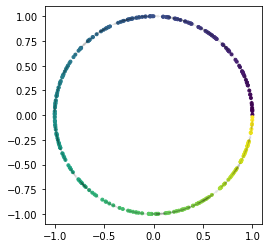

NameError: name 'device' is not defined

In [ ]:
from directed_graphs.datasets import (
    directed_circle,
    directed_cylinder,
    directed_spiral,
    directed_swiss_roll,
    directed_spiral_uniform,
    directed_swiss_roll_uniform,
)
from directed_graphs.datasets import plot_directed_2d, plot_directed_3d
from directed_graphs.diffusion_flow_embedding import DiffusionFlowEmbedder
import torch
import numpy as np

X, flow, labels = directed_circle(num_nodes=300, radius=1)
plot_directed_2d(X, flow, labels)
X = torch.tensor(X).float().to(device)
flow = torch.tensor(flow).float().to(device)


In [ ]:
MFE = MultiscaleDiffusionFlowEmbedder(X, flow, device=device).to(device)

  0%|          | 0/1000 [00:00<?, ?it/s]

Diffusion loss 0 is 2.03975510597229
Diffusion loss 1 is 2.73725962638855
Diffusion loss 2 is 3.0151374340057373
Diffusion loss 3 is 3.1220245361328125
EPOCH 0. Loss 3.1220245361328125. Flow strength 5.0. Heatmap of P embedding is 


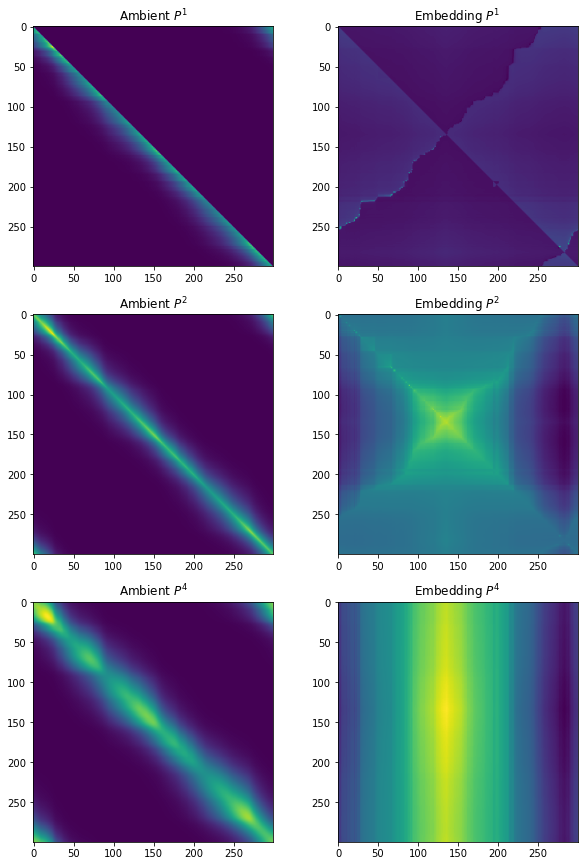

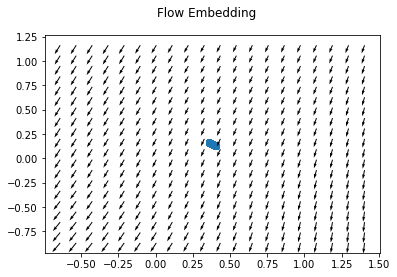

  0%|          | 2/1000 [00:01<11:27,  1.45it/s]

Diffusion loss 0 is 2.0292611122131348
Diffusion loss 1 is 2.730095863342285
Diffusion loss 2 is 3.0079665184020996
Diffusion loss 3 is 3.1147098541259766


  0%|          | 3/1000 [00:01<09:50,  1.69it/s]

Diffusion loss 0 is 2.0189754962921143
Diffusion loss 1 is 2.7233328819274902
Diffusion loss 2 is 3.0012006759643555
Diffusion loss 3 is 3.107822895050049


  0%|          | 4/1000 [00:02<09:01,  1.84it/s]

Diffusion loss 0 is 2.012047052383423
Diffusion loss 1 is 2.718916893005371
Diffusion loss 2 is 2.996764898300171
Diffusion loss 3 is 3.1032729148864746


  0%|          | 5/1000 [00:02<08:37,  1.92it/s]

Diffusion loss 0 is 2.0070102214813232
Diffusion loss 1 is 2.7159461975097656
Diffusion loss 2 is 2.993769884109497
Diffusion loss 3 is 3.1001739501953125


  1%|          | 6/1000 [00:03<08:21,  1.98it/s]

Diffusion loss 0 is 2.00260591506958
Diffusion loss 1 is 2.7136311531066895
Diffusion loss 2 is 2.9914305210113525
Diffusion loss 3 is 3.097743034362793


  1%|          | 7/1000 [00:03<08:19,  1.99it/s]

Diffusion loss 0 is 1.9991872310638428
Diffusion loss 1 is 2.7117888927459717
Diffusion loss 2 is 2.9895663261413574
Diffusion loss 3 is 3.095801830291748


  1%|          | 8/1000 [00:04<08:13,  2.01it/s]

Diffusion loss 0 is 1.9976664781570435
Diffusion loss 1 is 2.711923599243164
Diffusion loss 2 is 2.9896810054779053
Diffusion loss 3 is 3.095852851867676


  1%|          | 9/1000 [00:04<08:13,  2.01it/s]

Diffusion loss 0 is 1.99664306640625
Diffusion loss 1 is 2.7116823196411133
Diffusion loss 2 is 2.989410638809204
Diffusion loss 3 is 3.0955164432525635


  1%|          | 10/1000 [00:05<08:09,  2.02it/s]

Diffusion loss 0 is 1.9967330694198608
Diffusion loss 1 is 2.7120280265808105
Diffusion loss 2 is 2.9897289276123047
Diffusion loss 3 is 3.095778465270996


  1%|          | 11/1000 [00:05<07:59,  2.06it/s]

Diffusion loss 0 is 1.998558759689331
Diffusion loss 1 is 2.7139649391174316
Diffusion loss 2 is 2.9916367530822754
Diffusion loss 3 is 3.09763503074646


  1%|          | 12/1000 [00:06<08:02,  2.05it/s]

Diffusion loss 0 is 1.9998202323913574
Diffusion loss 1 is 2.715221405029297
Diffusion loss 2 is 2.992865562438965
Diffusion loss 3 is 3.0988197326660156


  1%|▏         | 13/1000 [00:06<07:56,  2.07it/s]

Diffusion loss 0 is 2.0002341270446777
Diffusion loss 1 is 2.71618390083313
Diffusion loss 2 is 2.993809461593628
Diffusion loss 3 is 3.099735736846924


  1%|▏         | 14/1000 [00:07<07:55,  2.07it/s]

Diffusion loss 0 is 2.002619981765747
Diffusion loss 1 is 2.7180428504943848
Diffusion loss 2 is 2.9956412315368652
Diffusion loss 3 is 3.1015336513519287


  2%|▏         | 15/1000 [00:07<07:49,  2.10it/s]

Diffusion loss 0 is 2.0064282417297363
Diffusion loss 1 is 2.720560312271118
Diffusion loss 2 is 2.998126268386841
Diffusion loss 3 is 3.1039843559265137


  2%|▏         | 16/1000 [00:08<07:50,  2.09it/s]

Diffusion loss 0 is 2.0098114013671875
Diffusion loss 1 is 2.7236435413360596
Diffusion loss 2 is 3.0011842250823975
Diffusion loss 3 is 3.1070220470428467


  2%|▏         | 17/1000 [00:08<07:59,  2.05it/s]

Diffusion loss 0 is 2.0133814811706543
Diffusion loss 1 is 2.726738691329956
Diffusion loss 2 is 3.0042521953582764
Diffusion loss 3 is 3.110074281692505


  2%|▏         | 18/1000 [00:09<07:55,  2.07it/s]

Diffusion loss 0 is 2.016296863555908
Diffusion loss 1 is 2.728565216064453
Diffusion loss 2 is 3.006044626235962
Diffusion loss 3 is 3.1118476390838623


  2%|▏         | 19/1000 [00:09<08:01,  2.04it/s]

Diffusion loss 0 is 2.0210165977478027
Diffusion loss 1 is 2.7318115234375
Diffusion loss 2 is 3.009251117706299
Diffusion loss 3 is 3.1150357723236084


  2%|▏         | 20/1000 [00:10<07:59,  2.04it/s]

Diffusion loss 0 is 2.024796724319458
Diffusion loss 1 is 2.734341621398926
Diffusion loss 2 is 3.0117392539978027
Diffusion loss 3 is 3.11751127243042


  2%|▏         | 21/1000 [00:10<07:54,  2.06it/s]

Diffusion loss 0 is 2.0307071208953857
Diffusion loss 1 is 2.7386395931243896
Diffusion loss 2 is 3.015990734100342
Diffusion loss 3 is 3.121751070022583


  2%|▏         | 22/1000 [00:11<07:53,  2.07it/s]

Diffusion loss 0 is 2.037219762802124
Diffusion loss 1 is 2.743382453918457
Diffusion loss 2 is 3.0206847190856934
Diffusion loss 3 is 3.126438617706299


  2%|▏         | 23/1000 [00:11<08:02,  2.03it/s]

Diffusion loss 0 is 2.0420148372650146
Diffusion loss 1 is 2.7462852001190186
Diffusion loss 2 is 3.023536205291748
Diffusion loss 3 is 3.1292808055877686


  2%|▏         | 24/1000 [00:12<07:57,  2.04it/s]

Diffusion loss 0 is 2.0466208457946777
Diffusion loss 1 is 2.7490015029907227
Diffusion loss 2 is 3.026197910308838
Diffusion loss 3 is 3.131936550140381


  2%|▎         | 25/1000 [00:12<07:50,  2.07it/s]

Diffusion loss 0 is 2.0530755519866943
Diffusion loss 1 is 2.7535979747772217
Diffusion loss 2 is 3.0307319164276123
Diffusion loss 3 is 3.1364657878875732


  3%|▎         | 26/1000 [00:13<07:47,  2.09it/s]

Diffusion loss 0 is 2.0579400062561035
Diffusion loss 1 is 2.7561774253845215
Diffusion loss 2 is 3.0332400798797607
Diffusion loss 3 is 3.138969898223877


  3%|▎         | 27/1000 [00:13<07:44,  2.09it/s]

Diffusion loss 0 is 2.064486026763916
Diffusion loss 1 is 2.7601006031036377
Diffusion loss 2 is 3.0370841026306152
Diffusion loss 3 is 3.1428120136260986


  3%|▎         | 28/1000 [00:14<07:44,  2.09it/s]

Diffusion loss 0 is 2.072329044342041
Diffusion loss 1 is 2.7650146484375
Diffusion loss 2 is 3.0419058799743652
Diffusion loss 3 is 3.147632360458374


  3%|▎         | 29/1000 [00:14<07:42,  2.10it/s]

Diffusion loss 0 is 2.0767548084259033
Diffusion loss 1 is 2.7665822505950928
Diffusion loss 2 is 3.0433719158172607
Diffusion loss 3 is 3.149101495742798


  3%|▎         | 30/1000 [00:14<07:40,  2.11it/s]

Diffusion loss 0 is 2.085530996322632
Diffusion loss 1 is 2.772172451019287
Diffusion loss 2 is 3.0488407611846924
Diffusion loss 3 is 3.154575824737549


  3%|▎         | 31/1000 [00:15<07:46,  2.08it/s]

Diffusion loss 0 is 2.0957610607147217
Diffusion loss 1 is 2.7790567874908447
Diffusion loss 2 is 3.055595874786377
Diffusion loss 3 is 3.161344051361084


  3%|▎         | 32/1000 [00:15<07:49,  2.06it/s]

Diffusion loss 0 is 2.1112711429595947
Diffusion loss 1 is 2.791167736053467
Diffusion loss 2 is 3.0675556659698486
Diffusion loss 3 is 3.173318862915039


  3%|▎         | 33/1000 [00:16<07:46,  2.07it/s]

Diffusion loss 0 is 2.124772548675537
Diffusion loss 1 is 2.800870418548584
Diffusion loss 2 is 3.077091932296753
Diffusion loss 3 is 3.1828761100769043


  3%|▎         | 34/1000 [00:16<07:38,  2.10it/s]

Diffusion loss 0 is 2.132888078689575
Diffusion loss 1 is 2.8044772148132324
Diffusion loss 2 is 3.0804951190948486
Diffusion loss 3 is 3.1862988471984863


  4%|▎         | 35/1000 [00:17<07:40,  2.09it/s]

Diffusion loss 0 is 2.1520133018493652
Diffusion loss 1 is 2.8193533420562744
Diffusion loss 2 is 3.095139265060425
Diffusion loss 3 is 3.2009644508361816


  4%|▎         | 36/1000 [00:17<07:38,  2.10it/s]

Diffusion loss 0 is 2.1742148399353027
Diffusion loss 1 is 2.8369531631469727
Diffusion loss 2 is 3.112487316131592
Diffusion loss 3 is 3.218341827392578


  4%|▎         | 37/1000 [00:18<07:32,  2.13it/s]

Diffusion loss 0 is 2.199885606765747
Diffusion loss 1 is 2.8578600883483887
Diffusion loss 2 is 3.1331076622009277
Diffusion loss 3 is 3.2389938831329346


  4%|▍         | 38/1000 [00:18<07:33,  2.12it/s]

Diffusion loss 0 is 2.219031572341919
Diffusion loss 1 is 2.8722925186157227
Diffusion loss 2 is 3.14723539352417
Diffusion loss 3 is 3.2531609535217285


  4%|▍         | 39/1000 [00:19<07:29,  2.14it/s]

Diffusion loss 0 is 2.250105142593384
Diffusion loss 1 is 2.8986165523529053
Diffusion loss 2 is 3.173224925994873
Diffusion loss 3 is 3.279193639755249


  4%|▍         | 40/1000 [00:19<07:32,  2.12it/s]

Diffusion loss 0 is 2.2882821559906006
Diffusion loss 1 is 2.932119846343994
Diffusion loss 2 is 3.206362009048462
Diffusion loss 3 is 3.3123767375946045


  4%|▍         | 41/1000 [00:20<07:30,  2.13it/s]

Diffusion loss 0 is 2.322924852371216
Diffusion loss 1 is 2.962155818939209
Diffusion loss 2 is 3.236011028289795
Diffusion loss 3 is 3.3420796394348145


  4%|▍         | 42/1000 [00:20<07:32,  2.12it/s]

Diffusion loss 0 is 2.3640329837799072
Diffusion loss 1 is 2.998786449432373
Diffusion loss 2 is 3.272233009338379
Diffusion loss 3 is 3.378357410430908


  4%|▍         | 43/1000 [00:21<07:34,  2.11it/s]

Diffusion loss 0 is 2.4036333560943604
Diffusion loss 1 is 3.0341620445251465
Diffusion loss 2 is 3.3071846961975098
Diffusion loss 3 is 3.41336727142334


  4%|▍         | 44/1000 [00:21<07:34,  2.10it/s]

Diffusion loss 0 is 2.454817295074463
Diffusion loss 1 is 3.0812571048736572
Diffusion loss 2 is 3.353847026824951
Diffusion loss 3 is 3.460090398788452


  4%|▍         | 45/1000 [00:22<07:42,  2.07it/s]

Diffusion loss 0 is 2.505533218383789
Diffusion loss 1 is 3.1282639503479004
Diffusion loss 2 is 3.4004430770874023
Diffusion loss 3 is 3.5067505836486816


  5%|▍         | 46/1000 [00:22<07:42,  2.06it/s]

Diffusion loss 0 is 2.5521721839904785
Diffusion loss 1 is 3.1716599464416504
Diffusion loss 2 is 3.4434680938720703
Diffusion loss 3 is 3.5498480796813965


  5%|▍         | 47/1000 [00:23<07:41,  2.06it/s]

Diffusion loss 0 is 2.601017951965332
Diffusion loss 1 is 3.21734619140625
Diffusion loss 2 is 3.488769769668579
Diffusion loss 3 is 3.595217227935791


  5%|▍         | 48/1000 [00:23<07:57,  1.99it/s]

Diffusion loss 0 is 2.6678476333618164
Diffusion loss 1 is 3.2811412811279297
Diffusion loss 2 is 3.5521552562713623
Diffusion loss 3 is 3.6586532592773438


  5%|▍         | 49/1000 [00:24<07:53,  2.01it/s]

Diffusion loss 0 is 2.7517495155334473
Diffusion loss 1 is 3.3624765872955322
Diffusion loss 2 is 3.6331326961517334
Diffusion loss 3 is 3.739685297012329


  5%|▌         | 50/1000 [00:24<07:52,  2.01it/s]

Diffusion loss 0 is 2.833007574081421
Diffusion loss 1 is 3.4416794776916504
Diffusion loss 2 is 3.7120327949523926
Diffusion loss 3 is 3.8186583518981934


  5%|▌         | 51/1000 [00:25<07:52,  2.01it/s]

Diffusion loss 0 is 2.9055113792419434
Diffusion loss 1 is 3.5122835636138916
Diffusion loss 2 is 3.782335042953491
Diffusion loss 3 is 3.889025926589966


  5%|▌         | 52/1000 [00:25<07:48,  2.02it/s]

Diffusion loss 0 is 2.983106851577759
Diffusion loss 1 is 3.5881240367889404
Diffusion loss 2 is 3.857867956161499
Diffusion loss 3 is 3.964601516723633


  5%|▌         | 53/1000 [00:26<07:45,  2.03it/s]

Diffusion loss 0 is 3.0704171657562256
Diffusion loss 1 is 3.674048900604248
Diffusion loss 2 is 3.943547248840332
Diffusion loss 3 is 4.050338268280029


  5%|▌         | 54/1000 [00:26<07:54,  1.99it/s]

Diffusion loss 0 is 3.1739323139190674
Diffusion loss 1 is 3.776221990585327
Diffusion loss 2 is 4.04547119140625
Diffusion loss 3 is 4.152300834655762


  6%|▌         | 55/1000 [00:27<07:48,  2.02it/s]

Diffusion loss 0 is 3.2653720378875732
Diffusion loss 1 is 3.8671157360076904
Diffusion loss 2 is 4.136215686798096
Diffusion loss 3 is 4.24311637878418


  6%|▌         | 56/1000 [00:27<07:40,  2.05it/s]

Diffusion loss 0 is 3.364753484725952
Diffusion loss 1 is 3.965951919555664
Diffusion loss 2 is 4.23487663269043
Diffusion loss 3 is 4.341814994812012


  6%|▌         | 57/1000 [00:28<07:41,  2.04it/s]

Diffusion loss 0 is 3.456723690032959
Diffusion loss 1 is 4.057671070098877
Diffusion loss 2 is 4.3264546394348145
Diffusion loss 3 is 4.433437824249268


  6%|▌         | 58/1000 [00:28<07:41,  2.04it/s]

Diffusion loss 0 is 3.54109787940979
Diffusion loss 1 is 4.1416401863098145
Diffusion loss 2 is 4.410285949707031
Diffusion loss 3 is 4.5173115730285645


  6%|▌         | 59/1000 [00:29<07:37,  2.06it/s]

Diffusion loss 0 is 3.6124675273895264
Diffusion loss 1 is 4.212712287902832
Diffusion loss 2 is 4.4812469482421875
Diffusion loss 3 is 4.588311672210693


  6%|▌         | 60/1000 [00:29<07:36,  2.06it/s]

Diffusion loss 0 is 3.684149980545044
Diffusion loss 1 is 4.284224033355713
Diffusion loss 2 is 4.552694320678711
Diffusion loss 3 is 4.659811019897461


  6%|▌         | 61/1000 [00:29<07:37,  2.05it/s]

Diffusion loss 0 is 3.755814790725708
Diffusion loss 1 is 4.355713844299316
Diffusion loss 2 is 4.624081611633301
Diffusion loss 3 is 4.73121452331543


  6%|▌         | 62/1000 [00:30<07:33,  2.07it/s]

Diffusion loss 0 is 3.826239585876465
Diffusion loss 1 is 4.425790786743164
Diffusion loss 2 is 4.6940999031066895
Diffusion loss 3 is 4.801302909851074


  6%|▋         | 63/1000 [00:30<07:32,  2.07it/s]

Diffusion loss 0 is 3.8880934715270996
Diffusion loss 1 is 4.48719596862793
Diffusion loss 2 is 4.755460739135742
Diffusion loss 3 is 4.862725257873535


  6%|▋         | 64/1000 [00:31<07:33,  2.07it/s]

Diffusion loss 0 is 3.9578845500946045
Diffusion loss 1 is 4.556700706481934
Diffusion loss 2 is 4.824909210205078
Diffusion loss 3 is 4.932220935821533


  6%|▋         | 65/1000 [00:31<07:32,  2.07it/s]

Diffusion loss 0 is 4.036159992218018
Diffusion loss 1 is 4.634644031524658
Diffusion loss 2 is 4.902827262878418
Diffusion loss 3 is 5.010200023651123


  7%|▋         | 66/1000 [00:32<07:40,  2.03it/s]

Diffusion loss 0 is 4.108985424041748
Diffusion loss 1 is 4.707339286804199
Diffusion loss 2 is 4.975471019744873
Diffusion loss 3 is 5.082864284515381


  7%|▋         | 67/1000 [00:32<07:49,  1.99it/s]

Diffusion loss 0 is 4.177502632141113
Diffusion loss 1 is 4.775913238525391
Diffusion loss 2 is 5.043994426727295
Diffusion loss 3 is 5.151389122009277


  7%|▋         | 68/1000 [00:33<07:43,  2.01it/s]

Diffusion loss 0 is 4.250778675079346
Diffusion loss 1 is 4.848609924316406
Diffusion loss 2 is 5.116585731506348
Diffusion loss 3 is 5.223998546600342


  7%|▋         | 69/1000 [00:33<07:38,  2.03it/s]

Diffusion loss 0 is 4.32791805267334
Diffusion loss 1 is 4.925227165222168
Diffusion loss 2 is 5.193116188049316
Diffusion loss 3 is 5.300550937652588


  7%|▋         | 70/1000 [00:34<07:33,  2.05it/s]

Diffusion loss 0 is 4.400700569152832
Diffusion loss 1 is 4.996689319610596
Diffusion loss 2 is 5.264405250549316
Diffusion loss 3 is 5.371856212615967


  7%|▋         | 71/1000 [00:34<07:39,  2.02it/s]

Diffusion loss 0 is 4.4817891120910645
Diffusion loss 1 is 5.077026844024658
Diffusion loss 2 is 5.344655513763428
Diffusion loss 3 is 5.452112674713135


  7%|▋         | 72/1000 [00:35<07:35,  2.04it/s]

Diffusion loss 0 is 4.568131923675537
Diffusion loss 1 is 5.162829399108887
Diffusion loss 2 is 5.430361747741699
Diffusion loss 3 is 5.537817478179932


  7%|▋         | 73/1000 [00:35<07:42,  2.00it/s]

Diffusion loss 0 is 4.634922027587891
Diffusion loss 1 is 5.22886848449707
Diffusion loss 2 is 5.496279716491699
Diffusion loss 3 is 5.603742599487305


  7%|▋         | 74/1000 [00:36<07:50,  1.97it/s]

Diffusion loss 0 is 4.698731422424316
Diffusion loss 1 is 5.292564392089844
Diffusion loss 2 is 5.559948921203613
Diffusion loss 3 is 5.667421817779541


  8%|▊         | 75/1000 [00:36<07:51,  1.96it/s]

Diffusion loss 0 is 4.782403469085693
Diffusion loss 1 is 5.376194477081299
Diffusion loss 2 is 5.643599987030029
Diffusion loss 3 is 5.751086711883545


  8%|▊         | 76/1000 [00:37<07:46,  1.98it/s]

Diffusion loss 0 is 4.858648300170898
Diffusion loss 1 is 5.452186584472656
Diffusion loss 2 is 5.719559669494629
Diffusion loss 3 is 5.827061176300049


  8%|▊         | 77/1000 [00:37<07:44,  1.99it/s]

Diffusion loss 0 is 4.942154407501221
Diffusion loss 1 is 5.535473346710205
Diffusion loss 2 is 5.80284309387207
Diffusion loss 3 is 5.910357475280762


  8%|▊         | 78/1000 [00:38<07:44,  1.98it/s]

Diffusion loss 0 is 4.980816841125488
Diffusion loss 1 is 5.573556900024414
Diffusion loss 2 is 5.840866565704346
Diffusion loss 3 is 5.948390960693359


  8%|▊         | 79/1000 [00:38<07:41,  1.99it/s]

Diffusion loss 0 is 4.983737945556641
Diffusion loss 1 is 5.576536655426025
Diffusion loss 2 is 5.843900203704834
Diffusion loss 3 is 5.951450824737549


  8%|▊         | 80/1000 [00:39<07:35,  2.02it/s]

Diffusion loss 0 is 5.002470970153809
Diffusion loss 1 is 5.595953941345215
Diffusion loss 2 is 5.863428115844727
Diffusion loss 3 is 5.970972061157227


  8%|▊         | 81/1000 [00:39<07:38,  2.01it/s]

Diffusion loss 0 is 5.013365268707275
Diffusion loss 1 is 5.60740852355957
Diffusion loss 2 is 5.875025749206543
Diffusion loss 3 is 5.982600212097168


  8%|▊         | 82/1000 [00:40<07:33,  2.02it/s]

Diffusion loss 0 is 5.014937400817871
Diffusion loss 1 is 5.608851909637451
Diffusion loss 2 is 5.87650203704834
Diffusion loss 3 is 5.984106540679932


  8%|▊         | 83/1000 [00:40<07:26,  2.05it/s]

Diffusion loss 0 is 5.036396026611328
Diffusion loss 1 is 5.6298956871032715
Diffusion loss 2 is 5.897563934326172
Diffusion loss 3 is 6.005195140838623


  8%|▊         | 84/1000 [00:41<07:30,  2.03it/s]

Diffusion loss 0 is 5.060315132141113
Diffusion loss 1 is 5.65366792678833
Diffusion loss 2 is 5.921413421630859
Diffusion loss 3 is 6.029091835021973


  8%|▊         | 85/1000 [00:41<07:25,  2.05it/s]

Diffusion loss 0 is 5.117713928222656
Diffusion loss 1 is 5.710878372192383
Diffusion loss 2 is 5.978695869445801
Diffusion loss 3 is 6.086450099945068


  9%|▊         | 86/1000 [00:42<07:19,  2.08it/s]

Diffusion loss 0 is 5.15546989440918
Diffusion loss 1 is 5.748571395874023
Diffusion loss 2 is 6.016458034515381
Diffusion loss 3 is 6.124281406402588


  9%|▊         | 87/1000 [00:42<07:06,  2.14it/s]

Diffusion loss 0 is 5.207911968231201
Diffusion loss 1 is 5.8009161949157715
Diffusion loss 2 is 6.068885803222656
Diffusion loss 3 is 6.176769256591797


  9%|▉         | 88/1000 [00:43<07:06,  2.14it/s]

Diffusion loss 0 is 5.2189435958862305
Diffusion loss 1 is 5.811193466186523
Diffusion loss 2 is 6.079214572906494
Diffusion loss 3 is 6.187180042266846


  9%|▉         | 89/1000 [00:43<07:05,  2.14it/s]

Diffusion loss 0 is 5.236286640167236
Diffusion loss 1 is 5.8288679122924805
Diffusion loss 2 is 6.097057819366455
Diffusion loss 3 is 6.205112934112549


  9%|▉         | 90/1000 [00:44<07:16,  2.09it/s]

Diffusion loss 0 is 5.239874839782715
Diffusion loss 1 is 5.833438396453857
Diffusion loss 2 is 6.101773738861084
Diffusion loss 3 is 6.209824562072754


  9%|▉         | 91/1000 [00:44<07:13,  2.09it/s]

Diffusion loss 0 is 5.269533157348633
Diffusion loss 1 is 5.863594055175781
Diffusion loss 2 is 6.132017612457275
Diffusion loss 3 is 6.24006986618042


  9%|▉         | 92/1000 [00:45<07:15,  2.08it/s]

Diffusion loss 0 is 5.2967424392700195
Diffusion loss 1 is 5.891350746154785
Diffusion loss 2 is 6.159935474395752
Diffusion loss 3 is 6.268002986907959


  9%|▉         | 93/1000 [00:45<07:18,  2.07it/s]

Diffusion loss 0 is 5.284158706665039
Diffusion loss 1 is 5.879601955413818
Diffusion loss 2 is 6.148329257965088
Diffusion loss 3 is 6.256409645080566


  9%|▉         | 94/1000 [00:46<07:17,  2.07it/s]

Diffusion loss 0 is 5.30442476272583
Diffusion loss 1 is 5.9002861976623535
Diffusion loss 2 is 6.1691131591796875
Diffusion loss 3 is 6.277200222015381


 10%|▉         | 95/1000 [00:46<07:16,  2.07it/s]

Diffusion loss 0 is 5.331946849822998
Diffusion loss 1 is 5.928137302398682
Diffusion loss 2 is 6.197081565856934
Diffusion loss 3 is 6.3051910400390625


 10%|▉         | 96/1000 [00:47<07:29,  2.01it/s]

Diffusion loss 0 is 5.368183612823486
Diffusion loss 1 is 5.964594841003418
Diffusion loss 2 is 6.2335638999938965
Diffusion loss 3 is 6.341667652130127


 10%|▉         | 97/1000 [00:47<07:29,  2.01it/s]

Diffusion loss 0 is 5.424108982086182
Diffusion loss 1 is 6.020517826080322
Diffusion loss 2 is 6.289473056793213
Diffusion loss 3 is 6.3975605964660645


 10%|▉         | 98/1000 [00:48<07:25,  2.02it/s]

Diffusion loss 0 is 5.432829856872559
Diffusion loss 1 is 6.029191017150879
Diffusion loss 2 is 6.29815149307251
Diffusion loss 3 is 6.406239986419678


 10%|▉         | 99/1000 [00:48<07:21,  2.04it/s]

Diffusion loss 0 is 5.474944591522217
Diffusion loss 1 is 6.071273326873779
Diffusion loss 2 is 6.340230464935303
Diffusion loss 3 is 6.448312759399414


 10%|█         | 100/1000 [00:49<07:20,  2.04it/s]

Diffusion loss 0 is 5.499778747558594
Diffusion loss 1 is 6.09612512588501
Diffusion loss 2 is 6.365105628967285
Diffusion loss 3 is 6.473206043243408
Diffusion loss 0 is 5.499994277954102
Diffusion loss 1 is 6.096709728240967
Diffusion loss 2 is 6.3657636642456055
Diffusion loss 3 is 6.473880767822266
EPOCH 100. Loss 6.473880767822266. Flow strength 5.0. Heatmap of P embedding is 


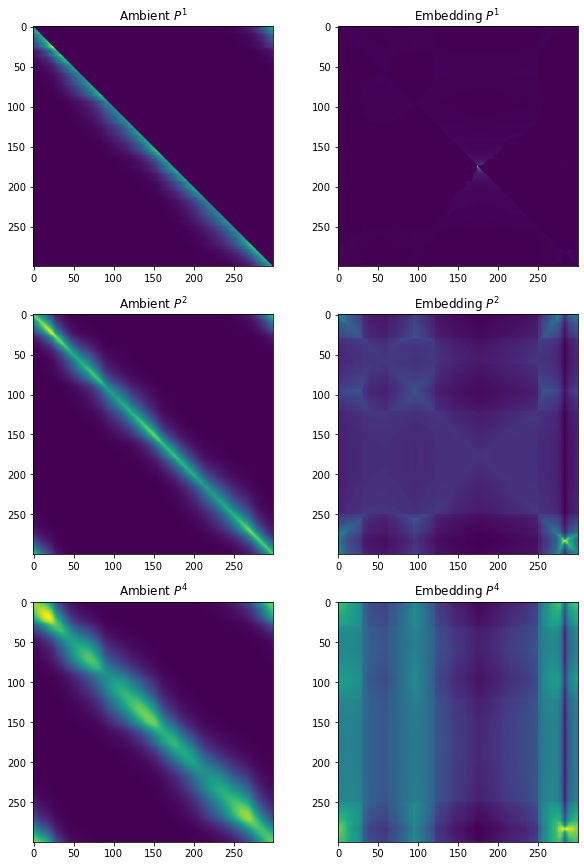

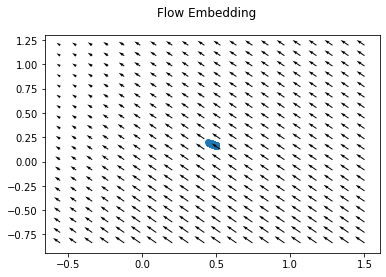

 10%|█         | 102/1000 [00:50<08:20,  1.80it/s]

Diffusion loss 0 is 5.473235607147217
Diffusion loss 1 is 6.0702033042907715
Diffusion loss 2 is 6.339330196380615
Diffusion loss 3 is 6.447473049163818


 10%|█         | 103/1000 [00:50<08:02,  1.86it/s]

Diffusion loss 0 is 5.344992160797119
Diffusion loss 1 is 5.9423041343688965
Diffusion loss 2 is 6.211526870727539
Diffusion loss 3 is 6.319693088531494


 10%|█         | 104/1000 [00:51<07:37,  1.96it/s]

Diffusion loss 0 is 5.331064224243164
Diffusion loss 1 is 5.928541660308838
Diffusion loss 2 is 6.197878837585449
Diffusion loss 3 is 6.306141376495361


 10%|█         | 105/1000 [00:51<07:27,  2.00it/s]

Diffusion loss 0 is 5.345742225646973
Diffusion loss 1 is 5.943017482757568
Diffusion loss 2 is 6.212438106536865
Diffusion loss 3 is 6.320810794830322


 11%|█         | 106/1000 [00:52<07:22,  2.02it/s]

Diffusion loss 0 is 5.370551586151123
Diffusion loss 1 is 5.966885566711426
Diffusion loss 2 is 6.236337661743164
Diffusion loss 3 is 6.344841003417969


 11%|█         | 107/1000 [00:52<07:21,  2.02it/s]

Diffusion loss 0 is 5.422659397125244
Diffusion loss 1 is 6.018204689025879
Diffusion loss 2 is 6.287646293640137
Diffusion loss 3 is 6.396261692047119


 11%|█         | 108/1000 [00:53<07:18,  2.03it/s]

Diffusion loss 0 is 5.466982364654541
Diffusion loss 1 is 6.061953544616699
Diffusion loss 2 is 6.331338882446289
Diffusion loss 3 is 6.440021514892578


 11%|█         | 109/1000 [00:53<07:21,  2.02it/s]

Diffusion loss 0 is 5.528647422790527
Diffusion loss 1 is 6.122838497161865
Diffusion loss 2 is 6.392098903656006
Diffusion loss 3 is 6.500798225402832


 11%|█         | 110/1000 [00:54<07:19,  2.02it/s]

Diffusion loss 0 is 5.574257850646973
Diffusion loss 1 is 6.167624473571777
Diffusion loss 2 is 6.436777591705322
Diffusion loss 3 is 6.54550313949585


 11%|█         | 111/1000 [00:54<07:18,  2.03it/s]

Diffusion loss 0 is 5.619692325592041
Diffusion loss 1 is 6.211854934692383
Diffusion loss 2 is 6.480871200561523
Diffusion loss 3 is 6.5896124839782715


 11%|█         | 112/1000 [00:55<07:19,  2.02it/s]

Diffusion loss 0 is 5.6691155433654785
Diffusion loss 1 is 6.2608642578125
Diffusion loss 2 is 6.5297675132751465
Diffusion loss 3 is 6.638502597808838


 11%|█▏        | 113/1000 [00:55<07:14,  2.04it/s]

Diffusion loss 0 is 5.720432281494141
Diffusion loss 1 is 6.311663627624512
Diffusion loss 2 is 6.5804667472839355
Diffusion loss 3 is 6.6891913414001465


 11%|█▏        | 114/1000 [00:56<07:15,  2.04it/s]

Diffusion loss 0 is 5.786249160766602
Diffusion loss 1 is 6.376924514770508
Diffusion loss 2 is 6.645636558532715
Diffusion loss 3 is 6.754351615905762


 12%|█▏        | 115/1000 [00:56<07:12,  2.05it/s]

Diffusion loss 0 is 5.829891204833984
Diffusion loss 1 is 6.420021057128906
Diffusion loss 2 is 6.6885552406311035
Diffusion loss 3 is 6.797219753265381


 12%|█▏        | 116/1000 [00:57<07:10,  2.05it/s]

Diffusion loss 0 is 5.871068477630615
Diffusion loss 1 is 6.460274696350098
Diffusion loss 2 is 6.7286152839660645
Diffusion loss 3 is 6.837244987487793


 12%|█▏        | 117/1000 [00:57<07:11,  2.05it/s]

Diffusion loss 0 is 5.992489814758301
Diffusion loss 1 is 6.5808491706848145
Diffusion loss 2 is 6.848996639251709
Diffusion loss 3 is 6.957601070404053


 12%|█▏        | 118/1000 [00:58<07:08,  2.06it/s]

Diffusion loss 0 is 6.055846214294434
Diffusion loss 1 is 6.643019199371338
Diffusion loss 2 is 6.910974502563477
Diffusion loss 3 is 7.019532203674316


 12%|█▏        | 119/1000 [00:58<07:11,  2.04it/s]

Diffusion loss 0 is 6.175665855407715
Diffusion loss 1 is 6.761777877807617
Diffusion loss 2 is 7.029616832733154
Diffusion loss 3 is 7.138182163238525


 12%|█▏        | 120/1000 [00:59<07:22,  1.99it/s]

Diffusion loss 0 is 6.283575057983398
Diffusion loss 1 is 6.868997097015381
Diffusion loss 2 is 7.13682222366333
Diffusion loss 3 is 7.245453834533691


 12%|█▏        | 121/1000 [00:59<07:21,  1.99it/s]

Diffusion loss 0 is 6.370048522949219
Diffusion loss 1 is 6.954488277435303
Diffusion loss 2 is 7.2222371101379395
Diffusion loss 3 is 7.330890655517578


 12%|█▏        | 122/1000 [01:00<07:21,  1.99it/s]

Diffusion loss 0 is 6.386755466461182
Diffusion loss 1 is 6.9706525802612305
Diffusion loss 2 is 7.238280296325684
Diffusion loss 3 is 7.346877574920654


 12%|█▏        | 123/1000 [01:00<07:24,  1.97it/s]

Diffusion loss 0 is 6.411212921142578
Diffusion loss 1 is 6.994761943817139
Diffusion loss 2 is 7.262314319610596
Diffusion loss 3 is 7.370904922485352


 12%|█▏        | 124/1000 [01:01<07:17,  2.00it/s]

Diffusion loss 0 is 6.412768363952637
Diffusion loss 1 is 6.996185779571533
Diffusion loss 2 is 7.263677597045898
Diffusion loss 3 is 7.372255802154541


 12%|█▎        | 125/1000 [01:01<07:14,  2.01it/s]

Diffusion loss 0 is 6.4177565574646
Diffusion loss 1 is 7.001051902770996
Diffusion loss 2 is 7.268502712249756
Diffusion loss 3 is 7.377071380615234


 13%|█▎        | 126/1000 [01:02<07:16,  2.00it/s]

Diffusion loss 0 is 6.438887596130371
Diffusion loss 1 is 7.021982192993164
Diffusion loss 2 is 7.289422988891602
Diffusion loss 3 is 7.39799690246582


 13%|█▎        | 127/1000 [01:02<07:14,  2.01it/s]

Diffusion loss 0 is 6.466792106628418
Diffusion loss 1 is 7.049732208251953
Diffusion loss 2 is 7.317075729370117
Diffusion loss 3 is 7.425604820251465


 13%|█▎        | 128/1000 [01:03<07:07,  2.04it/s]

Diffusion loss 0 is 6.474811553955078
Diffusion loss 1 is 7.057693004608154
Diffusion loss 2 is 7.325007915496826
Diffusion loss 3 is 7.433533191680908


 13%|█▎        | 129/1000 [01:03<07:05,  2.05it/s]

Diffusion loss 0 is 6.484582424163818
Diffusion loss 1 is 7.067434310913086
Diffusion loss 2 is 7.334718704223633
Diffusion loss 3 is 7.443238258361816


 13%|█▎        | 130/1000 [01:04<07:03,  2.06it/s]

Diffusion loss 0 is 6.502688884735107
Diffusion loss 1 is 7.085456371307373
Diffusion loss 2 is 7.352733135223389
Diffusion loss 3 is 7.46126127243042


 13%|█▎        | 131/1000 [01:04<07:00,  2.07it/s]

Diffusion loss 0 is 6.516218662261963
Diffusion loss 1 is 7.098977088928223
Diffusion loss 2 is 7.366218566894531
Diffusion loss 3 is 7.474731922149658


 13%|█▎        | 132/1000 [01:05<06:56,  2.08it/s]

Diffusion loss 0 is 6.513696670532227
Diffusion loss 1 is 7.096558570861816
Diffusion loss 2 is 7.363754749298096
Diffusion loss 3 is 7.472245216369629


 13%|█▎        | 133/1000 [01:05<06:54,  2.09it/s]

Diffusion loss 0 is 6.503399848937988
Diffusion loss 1 is 7.08630895614624
Diffusion loss 2 is 7.35345983505249
Diffusion loss 3 is 7.461925983428955


 13%|█▎        | 134/1000 [01:06<06:53,  2.09it/s]

Diffusion loss 0 is 6.512179851531982
Diffusion loss 1 is 7.095236301422119
Diffusion loss 2 is 7.362363815307617
Diffusion loss 3 is 7.47081184387207


 14%|█▎        | 135/1000 [01:06<06:52,  2.10it/s]

Diffusion loss 0 is 6.532444953918457
Diffusion loss 1 is 7.115674018859863
Diffusion loss 2 is 7.382816314697266
Diffusion loss 3 is 7.491260528564453


 14%|█▎        | 136/1000 [01:06<06:53,  2.09it/s]

Diffusion loss 0 is 6.53363561630249
Diffusion loss 1 is 7.116999626159668
Diffusion loss 2 is 7.384142875671387
Diffusion loss 3 is 7.492580413818359


 14%|█▎        | 137/1000 [01:07<06:53,  2.09it/s]

Diffusion loss 0 is 6.539397716522217
Diffusion loss 1 is 7.122920036315918
Diffusion loss 2 is 7.390068054199219
Diffusion loss 3 is 7.4985032081604


 14%|█▍        | 138/1000 [01:07<06:45,  2.12it/s]

Diffusion loss 0 is 6.530201435089111
Diffusion loss 1 is 7.11392068862915
Diffusion loss 2 is 7.381082534790039
Diffusion loss 3 is 7.4895195960998535


 14%|█▍        | 139/1000 [01:08<06:47,  2.11it/s]

Diffusion loss 0 is 6.53363561630249
Diffusion loss 1 is 7.1175689697265625
Diffusion loss 2 is 7.384732723236084
Diffusion loss 3 is 7.493175029754639


 14%|█▍        | 140/1000 [01:08<06:47,  2.11it/s]

Diffusion loss 0 is 6.529900550842285
Diffusion loss 1 is 7.114009380340576
Diffusion loss 2 is 7.381196022033691
Diffusion loss 3 is 7.489655017852783


 14%|█▍        | 141/1000 [01:09<06:47,  2.11it/s]

Diffusion loss 0 is 6.521722316741943
Diffusion loss 1 is 7.1060638427734375
Diffusion loss 2 is 7.373279094696045
Diffusion loss 3 is 7.481754779815674


 14%|█▍        | 142/1000 [01:09<06:41,  2.14it/s]

Diffusion loss 0 is 6.518465518951416
Diffusion loss 1 is 7.103052139282227
Diffusion loss 2 is 7.370311737060547
Diffusion loss 3 is 7.478806972503662


 14%|█▍        | 143/1000 [01:10<06:43,  2.13it/s]

Diffusion loss 0 is 6.511197090148926
Diffusion loss 1 is 7.095990180969238
Diffusion loss 2 is 7.3632965087890625
Diffusion loss 3 is 7.4718146324157715


 14%|█▍        | 144/1000 [01:10<06:53,  2.07it/s]

Diffusion loss 0 is 6.518250465393066
Diffusion loss 1 is 7.103304386138916
Diffusion loss 2 is 7.370654106140137
Diffusion loss 3 is 7.479190826416016


 14%|█▍        | 145/1000 [01:11<06:57,  2.05it/s]

Diffusion loss 0 is 6.525689601898193
Diffusion loss 1 is 7.110926151275635
Diffusion loss 2 is 7.378272533416748
Diffusion loss 3 is 7.4868268966674805


 15%|█▍        | 146/1000 [01:11<06:57,  2.05it/s]

Diffusion loss 0 is 6.523996829986572
Diffusion loss 1 is 7.109498500823975
Diffusion loss 2 is 7.376922607421875
Diffusion loss 3 is 7.485509872436523


 15%|█▍        | 147/1000 [01:12<06:53,  2.06it/s]

Diffusion loss 0 is 6.522687911987305
Diffusion loss 1 is 7.1084747314453125
Diffusion loss 2 is 7.375977039337158
Diffusion loss 3 is 7.484596252441406


 15%|█▍        | 148/1000 [01:12<06:50,  2.07it/s]

Diffusion loss 0 is 6.5222601890563965
Diffusion loss 1 is 7.1082963943481445
Diffusion loss 2 is 7.375864028930664
Diffusion loss 3 is 7.4845170974731445


 15%|█▍        | 149/1000 [01:13<06:49,  2.08it/s]

Diffusion loss 0 is 6.516529083251953
Diffusion loss 1 is 7.102811336517334
Diffusion loss 2 is 7.370441913604736
Diffusion loss 3 is 7.4791259765625


 15%|█▌        | 150/1000 [01:13<06:52,  2.06it/s]

Diffusion loss 0 is 6.5141730308532715
Diffusion loss 1 is 7.100712776184082
Diffusion loss 2 is 7.368415832519531
Diffusion loss 3 is 7.477129936218262


 15%|█▌        | 151/1000 [01:14<06:51,  2.06it/s]

Diffusion loss 0 is 6.500705718994141
Diffusion loss 1 is 7.087507247924805
Diffusion loss 2 is 7.35528564453125
Diffusion loss 3 is 7.464030742645264


 15%|█▌        | 152/1000 [01:14<06:56,  2.03it/s]

Diffusion loss 0 is 6.48459529876709
Diffusion loss 1 is 7.07165002822876
Diffusion loss 2 is 7.3394880294799805
Diffusion loss 3 is 7.4482622146606445


 15%|█▌        | 153/1000 [01:15<06:55,  2.04it/s]

Diffusion loss 0 is 6.482011795043945
Diffusion loss 1 is 7.069344520568848
Diffusion loss 2 is 7.337277412414551
Diffusion loss 3 is 7.446089267730713


 15%|█▌        | 154/1000 [01:15<06:50,  2.06it/s]

Diffusion loss 0 is 6.477871417999268
Diffusion loss 1 is 7.065436363220215
Diffusion loss 2 is 7.333425521850586
Diffusion loss 3 is 7.442266941070557


 16%|█▌        | 155/1000 [01:16<06:53,  2.04it/s]

Diffusion loss 0 is 6.472053050994873
Diffusion loss 1 is 7.059813976287842
Diffusion loss 2 is 7.3278656005859375
Diffusion loss 3 is 7.436738967895508


 16%|█▌        | 156/1000 [01:16<06:56,  2.03it/s]

Diffusion loss 0 is 6.4665985107421875
Diffusion loss 1 is 7.054559707641602
Diffusion loss 2 is 7.322671413421631
Diffusion loss 3 is 7.431575775146484


 16%|█▌        | 157/1000 [01:17<06:50,  2.05it/s]

Diffusion loss 0 is 6.4656453132629395
Diffusion loss 1 is 7.05380392074585
Diffusion loss 2 is 7.321977138519287
Diffusion loss 3 is 7.430912017822266


 16%|█▌        | 158/1000 [01:17<06:49,  2.06it/s]

Diffusion loss 0 is 6.460987091064453
Diffusion loss 1 is 7.049344539642334
Diffusion loss 2 is 7.317564964294434
Diffusion loss 3 is 7.426525592803955


 16%|█▌        | 159/1000 [01:18<06:46,  2.07it/s]

Diffusion loss 0 is 6.457934856414795
Diffusion loss 1 is 7.046521186828613
Diffusion loss 2 is 7.314817905426025
Diffusion loss 3 is 7.42380428314209


 16%|█▌        | 160/1000 [01:18<06:46,  2.07it/s]

Diffusion loss 0 is 6.451666831970215
Diffusion loss 1 is 7.040447235107422
Diffusion loss 2 is 7.308803081512451
Diffusion loss 3 is 7.417813301086426


 16%|█▌        | 161/1000 [01:19<06:46,  2.06it/s]

Diffusion loss 0 is 6.444648742675781
Diffusion loss 1 is 7.033660888671875
Diffusion loss 2 is 7.302082061767578
Diffusion loss 3 is 7.411116123199463


 16%|█▌        | 162/1000 [01:19<06:49,  2.05it/s]

Diffusion loss 0 is 6.438013076782227
Diffusion loss 1 is 7.02719259262085
Diffusion loss 2 is 7.295661449432373
Diffusion loss 3 is 7.404717922210693


 16%|█▋        | 163/1000 [01:20<07:01,  1.99it/s]

Diffusion loss 0 is 6.429450035095215
Diffusion loss 1 is 7.018774032592773
Diffusion loss 2 is 7.287292957305908
Diffusion loss 3 is 7.3963751792907715


 16%|█▋        | 164/1000 [01:20<06:55,  2.01it/s]

Diffusion loss 0 is 6.419259548187256
Diffusion loss 1 is 7.00877571105957
Diffusion loss 2 is 7.2773590087890625
Diffusion loss 3 is 7.386464595794678


 16%|█▋        | 165/1000 [01:21<06:54,  2.01it/s]

Diffusion loss 0 is 6.414787769317627
Diffusion loss 1 is 7.004441261291504
Diffusion loss 2 is 7.273070812225342
Diffusion loss 3 is 7.382201194763184


 17%|█▋        | 166/1000 [01:21<06:51,  2.03it/s]

Diffusion loss 0 is 6.412536144256592
Diffusion loss 1 is 7.002317905426025
Diffusion loss 2 is 7.270997524261475
Diffusion loss 3 is 7.380152225494385


 17%|█▋        | 167/1000 [01:22<06:51,  2.03it/s]

Diffusion loss 0 is 6.410750389099121
Diffusion loss 1 is 7.000671863555908
Diffusion loss 2 is 7.269404411315918
Diffusion loss 3 is 7.3785834312438965


 17%|█▋        | 168/1000 [01:22<06:48,  2.04it/s]

Diffusion loss 0 is 6.407662391662598
Diffusion loss 1 is 6.997723579406738
Diffusion loss 2 is 7.266497611999512
Diffusion loss 3 is 7.375698566436768


 17%|█▋        | 169/1000 [01:23<06:45,  2.05it/s]

Diffusion loss 0 is 6.403969764709473
Diffusion loss 1 is 6.994171142578125
Diffusion loss 2 is 7.2629876136779785
Diffusion loss 3 is 7.3722100257873535


 17%|█▋        | 170/1000 [01:23<06:43,  2.06it/s]

Diffusion loss 0 is 6.398262023925781
Diffusion loss 1 is 6.988638877868652
Diffusion loss 2 is 7.25752067565918
Diffusion loss 3 is 7.366765022277832


 17%|█▋        | 171/1000 [01:24<06:50,  2.02it/s]

Diffusion loss 0 is 6.394654273986816
Diffusion loss 1 is 6.985171794891357
Diffusion loss 2 is 7.254098892211914
Diffusion loss 3 is 7.363365173339844


 17%|█▋        | 172/1000 [01:24<06:52,  2.01it/s]

Diffusion loss 0 is 6.392330169677734
Diffusion loss 1 is 6.982992649078369
Diffusion loss 2 is 7.251969814300537
Diffusion loss 3 is 7.361259460449219


 17%|█▋        | 173/1000 [01:25<06:55,  1.99it/s]

Diffusion loss 0 is 6.385924816131592
Diffusion loss 1 is 6.976747512817383
Diffusion loss 2 is 7.245765209197998
Diffusion loss 3 is 7.355074405670166


 17%|█▋        | 174/1000 [01:25<06:53,  2.00it/s]

Diffusion loss 0 is 6.379782199859619
Diffusion loss 1 is 6.9707722663879395
Diffusion loss 2 is 7.239848613739014
Diffusion loss 3 is 7.349180698394775


 18%|█▊        | 175/1000 [01:26<06:43,  2.05it/s]

Diffusion loss 0 is 6.377206325531006
Diffusion loss 1 is 6.96836519241333
Diffusion loss 2 is 7.237486839294434
Diffusion loss 3 is 7.34683895111084


 18%|█▊        | 176/1000 [01:26<06:49,  2.01it/s]

Diffusion loss 0 is 6.371298313140869
Diffusion loss 1 is 6.962624549865723
Diffusion loss 2 is 7.231804370880127
Diffusion loss 3 is 7.341179370880127


 18%|█▊        | 177/1000 [01:27<06:49,  2.01it/s]

Diffusion loss 0 is 6.369543552398682
Diffusion loss 1 is 6.961040496826172
Diffusion loss 2 is 7.230274200439453
Diffusion loss 3 is 7.339670658111572


 18%|█▊        | 178/1000 [01:27<06:46,  2.02it/s]

Diffusion loss 0 is 6.365799427032471
Diffusion loss 1 is 6.957461357116699
Diffusion loss 2 is 7.226768493652344
Diffusion loss 3 is 7.336190223693848


 18%|█▊        | 179/1000 [01:27<06:44,  2.03it/s]

Diffusion loss 0 is 6.363340854644775
Diffusion loss 1 is 6.955168724060059
Diffusion loss 2 is 7.224531173706055
Diffusion loss 3 is 7.333974838256836


 18%|█▊        | 180/1000 [01:28<06:44,  2.03it/s]

Diffusion loss 0 is 6.360254764556885
Diffusion loss 1 is 6.952263832092285
Diffusion loss 2 is 7.221676826477051
Diffusion loss 3 is 7.331140041351318


 18%|█▊        | 181/1000 [01:29<06:51,  1.99it/s]

Diffusion loss 0 is 6.359091281890869
Diffusion loss 1 is 6.95126485824585
Diffusion loss 2 is 7.220726490020752
Diffusion loss 3 is 7.330211162567139


 18%|█▊        | 182/1000 [01:29<06:53,  1.98it/s]

Diffusion loss 0 is 6.356137752532959
Diffusion loss 1 is 6.948476314544678
Diffusion loss 2 is 7.21799898147583
Diffusion loss 3 is 7.327507495880127


 18%|█▊        | 183/1000 [01:30<06:56,  1.96it/s]

Diffusion loss 0 is 6.353737831115723
Diffusion loss 1 is 6.946262359619141
Diffusion loss 2 is 7.215847492218018
Diffusion loss 3 is 7.325376987457275


 18%|█▊        | 184/1000 [01:30<06:54,  1.97it/s]

Diffusion loss 0 is 6.352316856384277
Diffusion loss 1 is 6.945024490356445
Diffusion loss 2 is 7.214667320251465
Diffusion loss 3 is 7.32421875


 18%|█▊        | 185/1000 [01:31<06:52,  1.97it/s]

Diffusion loss 0 is 6.350625038146973
Diffusion loss 1 is 6.943505764007568
Diffusion loss 2 is 7.213208198547363
Diffusion loss 3 is 7.322782516479492


 19%|█▊        | 186/1000 [01:31<06:46,  2.00it/s]

Diffusion loss 0 is 6.349148273468018
Diffusion loss 1 is 6.942235946655273
Diffusion loss 2 is 7.211997985839844
Diffusion loss 3 is 7.321590423583984


 19%|█▊        | 187/1000 [01:32<06:41,  2.03it/s]

Diffusion loss 0 is 6.347304821014404
Diffusion loss 1 is 6.940607070922852
Diffusion loss 2 is 7.210438251495361
Diffusion loss 3 is 7.32004976272583


 19%|█▉        | 188/1000 [01:32<06:38,  2.04it/s]

Diffusion loss 0 is 6.346271991729736
Diffusion loss 1 is 6.939781188964844
Diffusion loss 2 is 7.209672927856445
Diffusion loss 3 is 7.319302558898926


 19%|█▉        | 189/1000 [01:32<06:35,  2.05it/s]

Diffusion loss 0 is 6.344757080078125
Diffusion loss 1 is 6.938443183898926
Diffusion loss 2 is 7.208402156829834
Diffusion loss 3 is 7.318054676055908


 19%|█▉        | 190/1000 [01:33<06:31,  2.07it/s]

Diffusion loss 0 is 6.3428120613098145
Diffusion loss 1 is 6.936678886413574
Diffusion loss 2 is 7.206702709197998
Diffusion loss 3 is 7.316375255584717


 19%|█▉        | 191/1000 [01:33<06:31,  2.07it/s]

Diffusion loss 0 is 6.340928077697754
Diffusion loss 1 is 6.934995174407959
Diffusion loss 2 is 7.205080986022949
Diffusion loss 3 is 7.314770221710205


 19%|█▉        | 192/1000 [01:34<06:29,  2.08it/s]

Diffusion loss 0 is 6.339548587799072
Diffusion loss 1 is 6.933799743652344
Diffusion loss 2 is 7.203946590423584
Diffusion loss 3 is 7.313654899597168


 19%|█▉        | 193/1000 [01:34<06:29,  2.07it/s]

Diffusion loss 0 is 6.337381362915039
Diffusion loss 1 is 6.93182897567749
Diffusion loss 2 is 7.202036380767822
Diffusion loss 3 is 7.311762809753418


 19%|█▉        | 194/1000 [01:35<06:30,  2.06it/s]

Diffusion loss 0 is 6.335491180419922
Diffusion loss 1 is 6.930113792419434
Diffusion loss 2 is 7.200369358062744
Diffusion loss 3 is 7.310113906860352


 20%|█▉        | 195/1000 [01:35<06:25,  2.09it/s]

Diffusion loss 0 is 6.333651065826416
Diffusion loss 1 is 6.928426742553711
Diffusion loss 2 is 7.198739528656006
Diffusion loss 3 is 7.308506965637207


 20%|█▉        | 196/1000 [01:36<06:32,  2.05it/s]

Diffusion loss 0 is 6.331992149353027
Diffusion loss 1 is 6.926973342895508
Diffusion loss 2 is 7.197351932525635
Diffusion loss 3 is 7.307137489318848


 20%|█▉        | 197/1000 [01:36<06:22,  2.10it/s]

Diffusion loss 0 is 6.330036640167236
Diffusion loss 1 is 6.925209999084473
Diffusion loss 2 is 7.195651531219482
Diffusion loss 3 is 7.305456161499023


 20%|█▉        | 198/1000 [01:37<06:19,  2.11it/s]

Diffusion loss 0 is 6.328657150268555
Diffusion loss 1 is 6.924005508422852
Diffusion loss 2 is 7.194499492645264
Diffusion loss 3 is 7.304322719573975


 20%|█▉        | 199/1000 [01:37<06:22,  2.10it/s]

Diffusion loss 0 is 6.327692031860352
Diffusion loss 1 is 6.923242092132568
Diffusion loss 2 is 7.1938042640686035
Diffusion loss 3 is 7.303646087646484


 20%|██        | 200/1000 [01:38<06:17,  2.12it/s]

Diffusion loss 0 is 6.325066089630127
Diffusion loss 1 is 6.920807838439941
Diffusion loss 2 is 7.191437721252441
Diffusion loss 3 is 7.301299095153809
Diffusion loss 0 is 6.323544979095459
Diffusion loss 1 is 6.919504642486572
Diffusion loss 2 is 7.190210819244385
Diffusion loss 3 is 7.300090312957764
EPOCH 200. Loss 7.300090312957764. Flow strength 5.0. Heatmap of P embedding is 


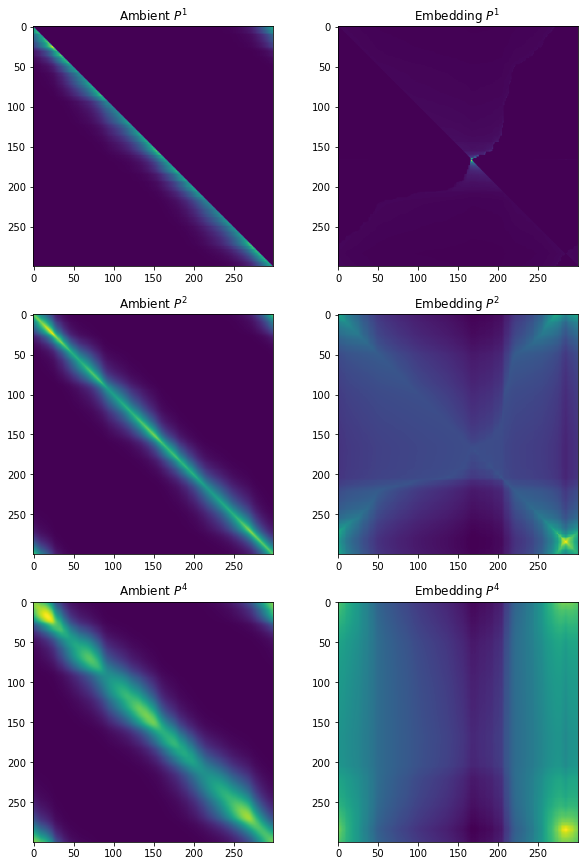

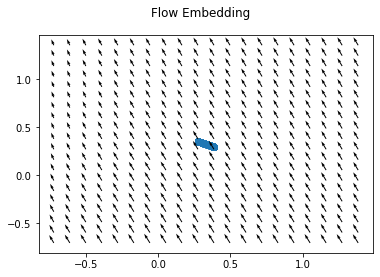

 20%|██        | 202/1000 [01:39<07:17,  1.83it/s]

Diffusion loss 0 is 6.322741985321045
Diffusion loss 1 is 6.918931007385254
Diffusion loss 2 is 7.189703941345215
Diffusion loss 3 is 7.299598217010498


 20%|██        | 203/1000 [01:40<07:05,  1.87it/s]

Diffusion loss 0 is 6.320585250854492
Diffusion loss 1 is 6.917019844055176
Diffusion loss 2 is 7.187854290008545
Diffusion loss 3 is 7.297760963439941


 20%|██        | 204/1000 [01:40<06:59,  1.90it/s]

Diffusion loss 0 is 6.319456577301025
Diffusion loss 1 is 6.916112899780273
Diffusion loss 2 is 7.187027454376221
Diffusion loss 3 is 7.296954154968262


 20%|██        | 205/1000 [01:41<06:50,  1.94it/s]

Diffusion loss 0 is 6.317010402679443
Diffusion loss 1 is 6.913835048675537
Diffusion loss 2 is 7.184808254241943
Diffusion loss 3 is 7.29475736618042


 21%|██        | 206/1000 [01:41<06:52,  1.92it/s]

Diffusion loss 0 is 6.315019607543945
Diffusion loss 1 is 6.912021636962891
Diffusion loss 2 is 7.183060169219971
Diffusion loss 3 is 7.293031215667725


 21%|██        | 207/1000 [01:42<06:54,  1.91it/s]

Diffusion loss 0 is 6.314259052276611
Diffusion loss 1 is 6.911486625671387
Diffusion loss 2 is 7.1825947761535645
Diffusion loss 3 is 7.2925848960876465


 21%|██        | 208/1000 [01:42<06:47,  1.94it/s]

Diffusion loss 0 is 6.313827991485596
Diffusion loss 1 is 6.911313533782959
Diffusion loss 2 is 7.182487487792969
Diffusion loss 3 is 7.292491436004639


 21%|██        | 209/1000 [01:43<06:45,  1.95it/s]

Diffusion loss 0 is 6.311731338500977
Diffusion loss 1 is 6.909470558166504
Diffusion loss 2 is 7.180724620819092
Diffusion loss 3 is 7.290747165679932


 21%|██        | 210/1000 [01:43<06:36,  1.99it/s]

Diffusion loss 0 is 6.3102874755859375
Diffusion loss 1 is 6.9082722663879395
Diffusion loss 2 is 7.179598331451416
Diffusion loss 3 is 7.289639472961426


 21%|██        | 211/1000 [01:44<06:36,  1.99it/s]

Diffusion loss 0 is 6.309597969055176
Diffusion loss 1 is 6.907873630523682
Diffusion loss 2 is 7.179278373718262
Diffusion loss 3 is 7.289333343505859


 21%|██        | 212/1000 [01:44<06:32,  2.01it/s]

Diffusion loss 0 is 6.308292865753174
Diffusion loss 1 is 6.906872272491455
Diffusion loss 2 is 7.1783599853515625
Diffusion loss 3 is 7.288427352905273


 21%|██▏       | 213/1000 [01:45<06:26,  2.04it/s]

Diffusion loss 0 is 6.306446552276611
Diffusion loss 1 is 6.9053425788879395
Diffusion loss 2 is 7.17691707611084
Diffusion loss 3 is 7.286996364593506


 21%|██▏       | 214/1000 [01:45<06:22,  2.05it/s]

Diffusion loss 0 is 6.305623531341553
Diffusion loss 1 is 6.904825210571289
Diffusion loss 2 is 7.176483154296875
Diffusion loss 3 is 7.2865753173828125


 22%|██▏       | 215/1000 [01:45<06:20,  2.06it/s]

Diffusion loss 0 is 6.303237438201904
Diffusion loss 1 is 6.902757167816162
Diffusion loss 2 is 7.1745076179504395
Diffusion loss 3 is 7.284612655639648


 22%|██▏       | 216/1000 [01:46<06:20,  2.06it/s]

Diffusion loss 0 is 6.302562236785889
Diffusion loss 1 is 6.902388095855713
Diffusion loss 2 is 7.174225330352783
Diffusion loss 3 is 7.284344673156738


 22%|██▏       | 217/1000 [01:46<06:18,  2.07it/s]

Diffusion loss 0 is 6.3008904457092285
Diffusion loss 1 is 6.901004791259766
Diffusion loss 2 is 7.17293119430542
Diffusion loss 3 is 7.283068656921387


 22%|██▏       | 218/1000 [01:47<06:12,  2.10it/s]

Diffusion loss 0 is 6.300303936004639
Diffusion loss 1 is 6.900711536407471
Diffusion loss 2 is 7.172723293304443
Diffusion loss 3 is 7.2828779220581055


 22%|██▏       | 219/1000 [01:47<06:17,  2.07it/s]

Diffusion loss 0 is 6.298389911651611
Diffusion loss 1 is 6.899105548858643
Diffusion loss 2 is 7.171204566955566
Diffusion loss 3 is 7.281374931335449


 22%|██▏       | 220/1000 [01:48<06:07,  2.12it/s]

Diffusion loss 0 is 6.296774387359619
Diffusion loss 1 is 6.897794723510742
Diffusion loss 2 is 7.1699748039245605
Diffusion loss 3 is 7.2801594734191895


 22%|██▏       | 221/1000 [01:48<06:05,  2.13it/s]

Diffusion loss 0 is 6.296182632446289
Diffusion loss 1 is 6.897543430328369
Diffusion loss 2 is 7.169819355010986
Diffusion loss 3 is 7.280017375946045


 22%|██▏       | 222/1000 [01:49<06:03,  2.14it/s]

Diffusion loss 0 is 6.296102523803711
Diffusion loss 1 is 6.8978047370910645
Diffusion loss 2 is 7.17017126083374
Diffusion loss 3 is 7.2803802490234375


 22%|██▏       | 223/1000 [01:49<06:06,  2.12it/s]

Diffusion loss 0 is 6.295217990875244
Diffusion loss 1 is 6.897256374359131
Diffusion loss 2 is 7.169706344604492
Diffusion loss 3 is 7.2799248695373535


 22%|██▏       | 224/1000 [01:50<06:05,  2.12it/s]

Diffusion loss 0 is 6.294277667999268
Diffusion loss 1 is 6.896657943725586
Diffusion loss 2 is 7.169213771820068
Diffusion loss 3 is 7.279446125030518


 22%|██▎       | 225/1000 [01:50<06:02,  2.14it/s]

Diffusion loss 0 is 6.293025493621826
Diffusion loss 1 is 6.895723819732666
Diffusion loss 2 is 7.168375015258789
Diffusion loss 3 is 7.278622627258301


 23%|██▎       | 226/1000 [01:51<06:00,  2.15it/s]

Diffusion loss 0 is 6.292055130004883
Diffusion loss 1 is 6.895068168640137
Diffusion loss 2 is 7.16780424118042
Diffusion loss 3 is 7.278065204620361


 23%|██▎       | 227/1000 [01:51<06:12,  2.07it/s]

Diffusion loss 0 is 6.290655136108398
Diffusion loss 1 is 6.893962860107422
Diffusion loss 2 is 7.166786193847656
Diffusion loss 3 is 7.277065277099609


 23%|██▎       | 228/1000 [01:52<06:07,  2.10it/s]

Diffusion loss 0 is 6.289546012878418
Diffusion loss 1 is 6.893168926239014
Diffusion loss 2 is 7.166076183319092
Diffusion loss 3 is 7.276371479034424


 23%|██▎       | 229/1000 [01:52<06:07,  2.10it/s]

Diffusion loss 0 is 6.288367748260498
Diffusion loss 1 is 6.892324447631836
Diffusion loss 2 is 7.165329933166504
Diffusion loss 3 is 7.275643348693848


 23%|██▎       | 230/1000 [01:53<06:06,  2.10it/s]

Diffusion loss 0 is 6.2877092361450195
Diffusion loss 1 is 6.891982555389404
Diffusion loss 2 is 7.165079116821289
Diffusion loss 3 is 7.275410175323486


 23%|██▎       | 231/1000 [01:53<06:05,  2.10it/s]

Diffusion loss 0 is 6.286772727966309
Diffusion loss 1 is 6.8913798332214355
Diffusion loss 2 is 7.164571762084961
Diffusion loss 3 is 7.2749176025390625


 23%|██▎       | 232/1000 [01:54<06:05,  2.10it/s]

Diffusion loss 0 is 6.287400722503662
Diffusion loss 1 is 6.892341613769531
Diffusion loss 2 is 7.16562032699585
Diffusion loss 3 is 7.2759785652160645


 23%|██▎       | 233/1000 [01:54<06:05,  2.10it/s]

Diffusion loss 0 is 6.286788463592529
Diffusion loss 1 is 6.892077922821045
Diffusion loss 2 is 7.165451526641846
Diffusion loss 3 is 7.275822639465332


 23%|██▎       | 234/1000 [01:55<06:08,  2.08it/s]

Diffusion loss 0 is 6.286257266998291
Diffusion loss 1 is 6.891904354095459
Diffusion loss 2 is 7.165379524230957
Diffusion loss 3 is 7.275763034820557


 24%|██▎       | 235/1000 [01:55<06:06,  2.09it/s]

Diffusion loss 0 is 6.285429000854492
Diffusion loss 1 is 6.891469478607178
Diffusion loss 2 is 7.165045261383057
Diffusion loss 3 is 7.2754364013671875


 24%|██▎       | 236/1000 [01:55<06:05,  2.09it/s]

Diffusion loss 0 is 6.285285472869873
Diffusion loss 1 is 6.891699314117432
Diffusion loss 2 is 7.165380001068115
Diffusion loss 3 is 7.275783538818359


 24%|██▎       | 237/1000 [01:56<06:02,  2.11it/s]

Diffusion loss 0 is 6.2843828201293945
Diffusion loss 1 is 6.891227722167969
Diffusion loss 2 is 7.165025234222412
Diffusion loss 3 is 7.275437355041504


 24%|██▍       | 238/1000 [01:56<06:01,  2.11it/s]

Diffusion loss 0 is 6.283782005310059
Diffusion loss 1 is 6.891095161437988
Diffusion loss 2 is 7.164994239807129
Diffusion loss 3 is 7.275406837463379


 24%|██▍       | 239/1000 [01:57<06:02,  2.10it/s]

Diffusion loss 0 is 6.282778739929199
Diffusion loss 1 is 6.890543460845947
Diffusion loss 2 is 7.164555072784424
Diffusion loss 3 is 7.274972915649414


 24%|██▍       | 240/1000 [01:57<06:02,  2.10it/s]

Diffusion loss 0 is 6.28210973739624
Diffusion loss 1 is 6.8903093338012695
Diffusion loss 2 is 7.164427757263184
Diffusion loss 3 is 7.274852275848389


 24%|██▍       | 241/1000 [01:58<06:00,  2.10it/s]

Diffusion loss 0 is 6.28136682510376
Diffusion loss 1 is 6.890007972717285
Diffusion loss 2 is 7.164236068725586
Diffusion loss 3 is 7.274672985076904


 24%|██▍       | 242/1000 [01:58<05:55,  2.13it/s]

Diffusion loss 0 is 6.281215667724609
Diffusion loss 1 is 6.890303611755371
Diffusion loss 2 is 7.164648056030273
Diffusion loss 3 is 7.275094985961914


 24%|██▍       | 243/1000 [01:59<05:58,  2.11it/s]

Diffusion loss 0 is 6.282698631286621
Diffusion loss 1 is 6.892261505126953
Diffusion loss 2 is 7.166714668273926
Diffusion loss 3 is 7.277167797088623


 24%|██▍       | 244/1000 [01:59<05:56,  2.12it/s]

Diffusion loss 0 is 6.281570911407471
Diffusion loss 1 is 6.891645908355713
Diffusion loss 2 is 7.166227340698242
Diffusion loss 3 is 7.276682376861572


 24%|██▍       | 245/1000 [02:00<05:55,  2.12it/s]

Diffusion loss 0 is 6.280299663543701
Diffusion loss 1 is 6.8909125328063965
Diffusion loss 2 is 7.165618419647217
Diffusion loss 3 is 7.276068687438965


 25%|██▍       | 246/1000 [02:00<06:09,  2.04it/s]

Diffusion loss 0 is 6.2791829109191895
Diffusion loss 1 is 6.89030122756958
Diffusion loss 2 is 7.165118217468262
Diffusion loss 3 is 7.275563716888428


 25%|██▍       | 247/1000 [02:01<06:06,  2.06it/s]

Diffusion loss 0 is 6.277928352355957
Diffusion loss 1 is 6.8895583152771
Diffusion loss 2 is 7.164485931396484
Diffusion loss 3 is 7.274930000305176


 25%|██▍       | 248/1000 [02:01<06:03,  2.07it/s]

Diffusion loss 0 is 6.2770185470581055
Diffusion loss 1 is 6.889136791229248
Diffusion loss 2 is 7.164184093475342
Diffusion loss 3 is 7.2746405601501465


 25%|██▍       | 249/1000 [02:02<06:02,  2.07it/s]

Diffusion loss 0 is 6.2767333984375
Diffusion loss 1 is 6.889347553253174
Diffusion loss 2 is 7.164516925811768
Diffusion loss 3 is 7.274985313415527


 25%|██▌       | 250/1000 [02:02<06:00,  2.08it/s]

Diffusion loss 0 is 6.275850772857666
Diffusion loss 1 is 6.889028549194336
Diffusion loss 2 is 7.164322853088379
Diffusion loss 3 is 7.2747883796691895


 25%|██▌       | 251/1000 [02:03<05:59,  2.08it/s]

Diffusion loss 0 is 6.274933338165283
Diffusion loss 1 is 6.888647079467773
Diffusion loss 2 is 7.164059638977051
Diffusion loss 3 is 7.274523735046387


 25%|██▌       | 252/1000 [02:03<05:57,  2.09it/s]

Diffusion loss 0 is 6.273187637329102
Diffusion loss 1 is 6.887395858764648
Diffusion loss 2 is 7.162928104400635
Diffusion loss 3 is 7.2733917236328125


 25%|██▌       | 253/1000 [02:04<05:59,  2.08it/s]

Diffusion loss 0 is 6.272842884063721
Diffusion loss 1 is 6.8876471519470215
Diffusion loss 2 is 7.163303375244141
Diffusion loss 3 is 7.273754119873047


 25%|██▌       | 254/1000 [02:04<05:55,  2.10it/s]

Diffusion loss 0 is 6.273798942565918
Diffusion loss 1 is 6.889201641082764
Diffusion loss 2 is 7.164972305297852
Diffusion loss 3 is 7.275411128997803


 26%|██▌       | 255/1000 [02:05<05:54,  2.10it/s]

Diffusion loss 0 is 6.272754669189453
Diffusion loss 1 is 6.888747215270996
Diffusion loss 2 is 7.164647579193115
Diffusion loss 3 is 7.275082588195801


 26%|██▌       | 256/1000 [02:05<05:53,  2.11it/s]

Diffusion loss 0 is 6.272066593170166
Diffusion loss 1 is 6.888532638549805
Diffusion loss 2 is 7.16455602645874
Diffusion loss 3 is 7.275012969970703


 26%|██▌       | 257/1000 [02:05<05:49,  2.13it/s]

Diffusion loss 0 is 6.273244857788086
Diffusion loss 1 is 6.890234470367432
Diffusion loss 2 is 7.166383743286133
Diffusion loss 3 is 7.276845932006836


 26%|██▌       | 258/1000 [02:06<05:46,  2.14it/s]

Diffusion loss 0 is 6.272656440734863
Diffusion loss 1 is 6.890226364135742
Diffusion loss 2 is 7.166491508483887
Diffusion loss 3 is 7.276943206787109


 26%|██▌       | 259/1000 [02:06<05:55,  2.09it/s]

Diffusion loss 0 is 6.274811744689941
Diffusion loss 1 is 6.892965316772461
Diffusion loss 2 is 7.16934871673584
Diffusion loss 3 is 7.279793739318848


 26%|██▌       | 260/1000 [02:07<05:51,  2.11it/s]

Diffusion loss 0 is 6.273268222808838
Diffusion loss 1 is 6.892002582550049
Diffusion loss 2 is 7.16849946975708
Diffusion loss 3 is 7.278934478759766


 26%|██▌       | 261/1000 [02:07<05:49,  2.11it/s]

Diffusion loss 0 is 6.270754337310791
Diffusion loss 1 is 6.890054225921631
Diffusion loss 2 is 7.16666841506958
Diffusion loss 3 is 7.27709436416626


 26%|██▌       | 262/1000 [02:08<05:53,  2.09it/s]

Diffusion loss 0 is 6.271125793457031
Diffusion loss 1 is 6.890951633453369
Diffusion loss 2 is 7.1676926612854
Diffusion loss 3 is 7.2781219482421875


 26%|██▋       | 263/1000 [02:08<05:52,  2.09it/s]

Diffusion loss 0 is 6.269778728485107
Diffusion loss 1 is 6.890154838562012
Diffusion loss 2 is 7.167013645172119
Diffusion loss 3 is 7.277441501617432


 26%|██▋       | 264/1000 [02:09<05:53,  2.08it/s]

Diffusion loss 0 is 6.265632629394531
Diffusion loss 1 is 6.886617660522461
Diffusion loss 2 is 7.16359281539917
Diffusion loss 3 is 7.273998737335205


 26%|██▋       | 265/1000 [02:09<05:53,  2.08it/s]

Diffusion loss 0 is 6.266018390655518
Diffusion loss 1 is 6.887603282928467
Diffusion loss 2 is 7.164683818817139
Diffusion loss 3 is 7.275060653686523


 27%|██▋       | 266/1000 [02:10<05:52,  2.08it/s]

Diffusion loss 0 is 6.265402793884277
Diffusion loss 1 is 6.8875298500061035
Diffusion loss 2 is 7.164727687835693
Diffusion loss 3 is 7.275105953216553


 27%|██▋       | 267/1000 [02:10<05:54,  2.07it/s]

Diffusion loss 0 is 6.264475345611572
Diffusion loss 1 is 6.887038230895996
Diffusion loss 2 is 7.164344787597656
Diffusion loss 3 is 7.274714469909668


 27%|██▋       | 268/1000 [02:11<05:44,  2.12it/s]

Diffusion loss 0 is 6.261383056640625
Diffusion loss 1 is 6.883955478668213
Diffusion loss 2 is 7.161334991455078
Diffusion loss 3 is 7.271647930145264


 27%|██▋       | 269/1000 [02:11<05:45,  2.12it/s]

Diffusion loss 0 is 6.261701583862305
Diffusion loss 1 is 6.883580684661865
Diffusion loss 2 is 7.161041736602783
Diffusion loss 3 is 7.2713751792907715


 27%|██▋       | 270/1000 [02:12<05:47,  2.10it/s]

Diffusion loss 0 is 6.267710208892822
Diffusion loss 1 is 6.88992977142334
Diffusion loss 2 is 7.167638778686523
Diffusion loss 3 is 7.278119087219238


 27%|██▋       | 271/1000 [02:12<05:45,  2.11it/s]

Diffusion loss 0 is 6.25568151473999
Diffusion loss 1 is 6.878565788269043
Diffusion loss 2 is 7.156843662261963
Diffusion loss 3 is 7.267836570739746


 27%|██▋       | 272/1000 [02:13<05:44,  2.11it/s]

Diffusion loss 0 is 6.244182109832764
Diffusion loss 1 is 6.867252349853516
Diffusion loss 2 is 7.146116256713867
Diffusion loss 3 is 7.257583141326904


 27%|██▋       | 273/1000 [02:13<05:42,  2.12it/s]

Diffusion loss 0 is 6.228621959686279
Diffusion loss 1 is 6.851802825927734
Diffusion loss 2 is 7.131226539611816
Diffusion loss 3 is 7.243093967437744


 27%|██▋       | 274/1000 [02:14<05:43,  2.11it/s]

Diffusion loss 0 is 6.214014053344727
Diffusion loss 1 is 6.837202548980713
Diffusion loss 2 is 7.117147445678711
Diffusion loss 3 is 7.229361534118652


 28%|██▊       | 275/1000 [02:14<05:41,  2.12it/s]

Diffusion loss 0 is 6.20033597946167
Diffusion loss 1 is 6.823360443115234
Diffusion loss 2 is 7.103989601135254
Diffusion loss 3 is 7.216666221618652


 28%|██▊       | 276/1000 [02:15<05:42,  2.11it/s]

Diffusion loss 0 is 6.1912055015563965
Diffusion loss 1 is 6.814488410949707
Diffusion loss 2 is 7.095688819885254
Diffusion loss 3 is 7.2086567878723145


 28%|██▊       | 277/1000 [02:15<05:39,  2.13it/s]

Diffusion loss 0 is 6.17034387588501
Diffusion loss 1 is 6.793891906738281
Diffusion loss 2 is 7.075628280639648
Diffusion loss 3 is 7.188848495483398


 28%|██▊       | 278/1000 [02:15<05:42,  2.11it/s]

Diffusion loss 0 is 6.15336799621582
Diffusion loss 1 is 6.777338027954102
Diffusion loss 2 is 7.059620380401611
Diffusion loss 3 is 7.173064231872559


 28%|██▊       | 279/1000 [02:16<05:51,  2.05it/s]

Diffusion loss 0 is 6.136073589324951
Diffusion loss 1 is 6.760651111602783
Diffusion loss 2 is 7.043425559997559
Diffusion loss 3 is 7.157032012939453


 28%|██▊       | 280/1000 [02:16<05:48,  2.07it/s]

Diffusion loss 0 is 6.1205244064331055
Diffusion loss 1 is 6.745795726776123
Diffusion loss 2 is 7.029045581817627
Diffusion loss 3 is 7.142786979675293


 28%|██▊       | 281/1000 [02:17<05:51,  2.04it/s]

Diffusion loss 0 is 6.107326030731201
Diffusion loss 1 is 6.733419418334961
Diffusion loss 2 is 7.017035007476807
Diffusion loss 3 is 7.1308274269104


 28%|██▊       | 282/1000 [02:17<05:49,  2.06it/s]

Diffusion loss 0 is 6.094951152801514
Diffusion loss 1 is 6.721971035003662
Diffusion loss 2 is 7.005856513977051
Diffusion loss 3 is 7.11964225769043


 28%|██▊       | 283/1000 [02:18<05:52,  2.04it/s]

Diffusion loss 0 is 6.081467151641846
Diffusion loss 1 is 6.709475994110107
Diffusion loss 2 is 6.993545055389404
Diffusion loss 3 is 7.107264518737793


 28%|██▊       | 284/1000 [02:18<05:54,  2.02it/s]

Diffusion loss 0 is 6.070034503936768
Diffusion loss 1 is 6.699057102203369
Diffusion loss 2 is 6.983234882354736
Diffusion loss 3 is 7.09684944152832


 28%|██▊       | 285/1000 [02:19<05:51,  2.03it/s]

Diffusion loss 0 is 6.05271577835083
Diffusion loss 1 is 6.682714939117432
Diffusion loss 2 is 6.967071056365967
Diffusion loss 3 is 7.080641269683838


 29%|██▊       | 286/1000 [02:19<05:43,  2.08it/s]

Diffusion loss 0 is 6.037919998168945
Diffusion loss 1 is 6.668928623199463
Diffusion loss 2 is 6.953463554382324
Diffusion loss 3 is 7.0669941902160645


 29%|██▊       | 287/1000 [02:20<05:52,  2.03it/s]

Diffusion loss 0 is 6.025206089019775
Diffusion loss 1 is 6.657227039337158
Diffusion loss 2 is 6.94187593460083
Diffusion loss 3 is 7.055328845977783


 29%|██▉       | 288/1000 [02:20<05:48,  2.04it/s]

Diffusion loss 0 is 6.010578155517578
Diffusion loss 1 is 6.643560409545898
Diffusion loss 2 is 6.928254127502441
Diffusion loss 3 is 7.041598320007324


 29%|██▉       | 289/1000 [02:21<05:53,  2.01it/s]

Diffusion loss 0 is 5.99567985534668
Diffusion loss 1 is 6.6296000480651855
Diffusion loss 2 is 6.914327144622803
Diffusion loss 3 is 7.027562618255615


 29%|██▉       | 290/1000 [02:21<05:56,  1.99it/s]

Diffusion loss 0 is 5.980838775634766
Diffusion loss 1 is 6.615710258483887
Diffusion loss 2 is 6.900392532348633
Diffusion loss 3 is 7.013477325439453


 29%|██▉       | 291/1000 [02:22<05:52,  2.01it/s]

Diffusion loss 0 is 5.965755462646484
Diffusion loss 1 is 6.601563453674316
Diffusion loss 2 is 6.886212348937988
Diffusion loss 3 is 6.999160289764404


 29%|██▉       | 292/1000 [02:22<05:46,  2.04it/s]

Diffusion loss 0 is 5.9512248039245605
Diffusion loss 1 is 6.587932586669922
Diffusion loss 2 is 6.872469902038574
Diffusion loss 3 is 6.985241413116455


 29%|██▉       | 293/1000 [02:23<05:42,  2.06it/s]

Diffusion loss 0 is 5.9371657371521
Diffusion loss 1 is 6.574778079986572
Diffusion loss 2 is 6.859223365783691
Diffusion loss 3 is 6.971837043762207


 29%|██▉       | 294/1000 [02:23<05:38,  2.08it/s]

Diffusion loss 0 is 5.921340465545654
Diffusion loss 1 is 6.559799671173096
Diffusion loss 2 is 6.844103813171387
Diffusion loss 3 is 6.956538677215576


 30%|██▉       | 295/1000 [02:24<05:38,  2.08it/s]

Diffusion loss 0 is 5.905215740203857
Diffusion loss 1 is 6.5445098876953125
Diffusion loss 2 is 6.8287034034729
Diffusion loss 3 is 6.940987586975098


 30%|██▉       | 296/1000 [02:24<05:36,  2.09it/s]

Diffusion loss 0 is 5.891111373901367
Diffusion loss 1 is 6.531189918518066
Diffusion loss 2 is 6.815183162689209
Diffusion loss 3 is 6.92726993560791


 30%|██▉       | 297/1000 [02:25<05:35,  2.10it/s]

Diffusion loss 0 is 5.878739356994629
Diffusion loss 1 is 6.519484519958496
Diffusion loss 2 is 6.803241729736328
Diffusion loss 3 is 6.9151225090026855


 30%|██▉       | 298/1000 [02:25<05:38,  2.07it/s]

Diffusion loss 0 is 5.863198757171631
Diffusion loss 1 is 6.50465726852417
Diffusion loss 2 is 6.788244724273682
Diffusion loss 3 is 6.899957656860352


 30%|██▉       | 299/1000 [02:26<05:36,  2.09it/s]

Diffusion loss 0 is 5.8482346534729
Diffusion loss 1 is 6.490304946899414
Diffusion loss 2 is 6.773712158203125
Diffusion loss 3 is 6.885264873504639


 30%|███       | 300/1000 [02:26<05:34,  2.09it/s]

Diffusion loss 0 is 5.833312511444092
Diffusion loss 1 is 6.475955486297607
Diffusion loss 2 is 6.7591423988342285
Diffusion loss 3 is 6.8705153465271
Diffusion loss 0 is 5.816686153411865
Diffusion loss 1 is 6.459866523742676
Diffusion loss 2 is 6.742828369140625
Diffusion loss 3 is 6.854021072387695
EPOCH 300. Loss 6.854021072387695. Flow strength 5.0. Heatmap of P embedding is 


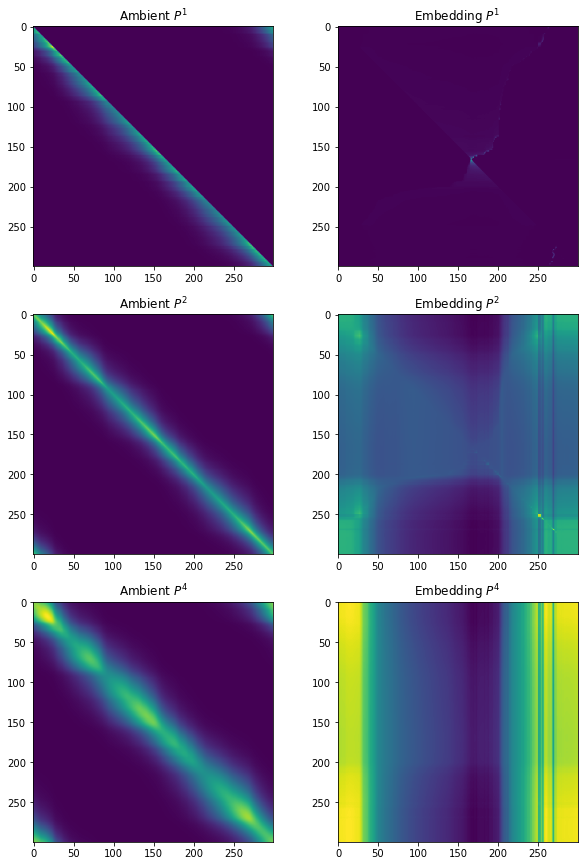

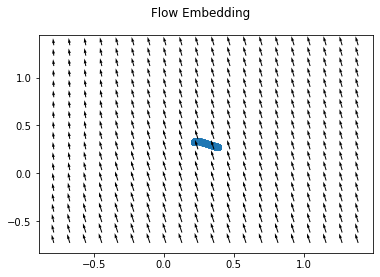

 30%|███       | 302/1000 [02:27<06:18,  1.84it/s]

Diffusion loss 0 is 5.804393768310547
Diffusion loss 1 is 6.448009490966797
Diffusion loss 2 is 6.730683326721191
Diffusion loss 3 is 6.84166955947876


 30%|███       | 302/1000 [02:28<05:42,  2.04it/s]


KeyboardInterrupt: 

In [ ]:
MFE.fit(n_steps=1000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


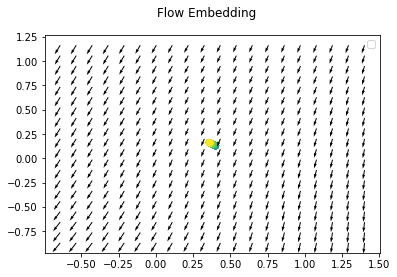

In [ ]:
MFE.visualize_points(labels=labels)

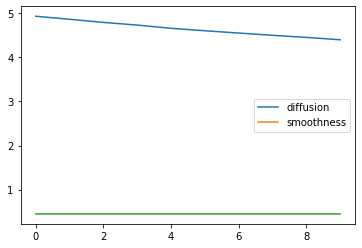

In [ ]:
plt.plot(MFE.losses["diffusion"], label="diffusion")
plt.plot(MFE.losses["smoothness"], label="smoothness")
plt.plot(MFE.losses["reconstruction"])
plt.legend()

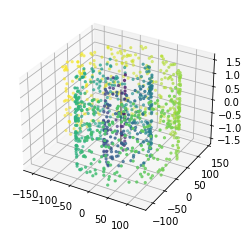

In [ ]:
X, flow, labels = directed_swiss_roll_uniform(
    num_nodes=1000, num_spirals=2.5, radius=10, height=3, xtilt=0, ytilt=0
)
plot_directed_3d(X, flow, labels, mask_prob=0.5)

In [ ]:
X = torch.tensor(X)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [ ]:
MFE = MultiscaleDiffusionFlowEmbedder(X, flow, device=device).to(device)


  0%|          | 0/10000 [00:00<?, ?it/s]

EPOCH 0. Loss 11.891934394836426. Flow strength 4.999000072479248. Heatmap of P embedding is 


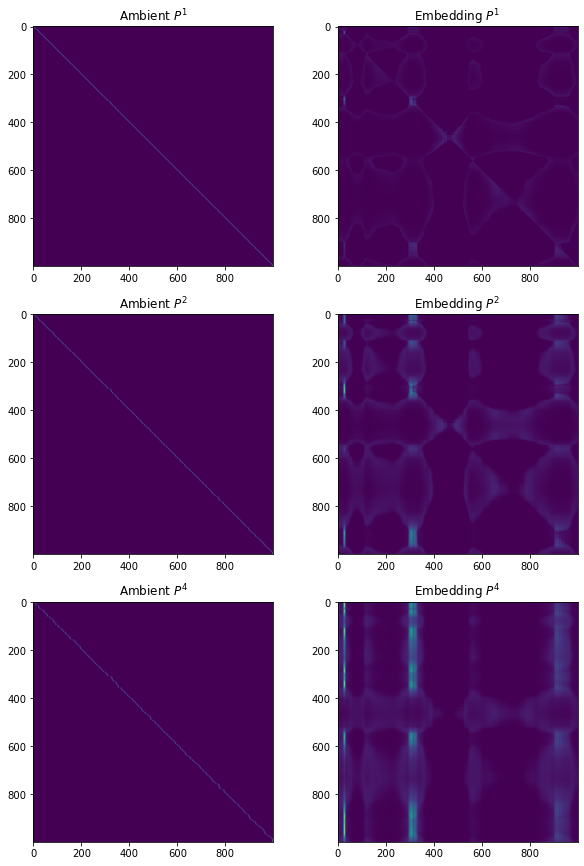

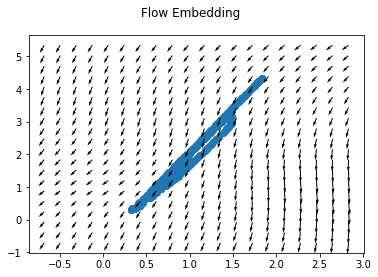

  1%|          | 100/10000 [00:15<19:12,  8.59it/s]

EPOCH 100. Loss 8.272184371948242. Flow strength 4.952264785766602. Heatmap of P embedding is 


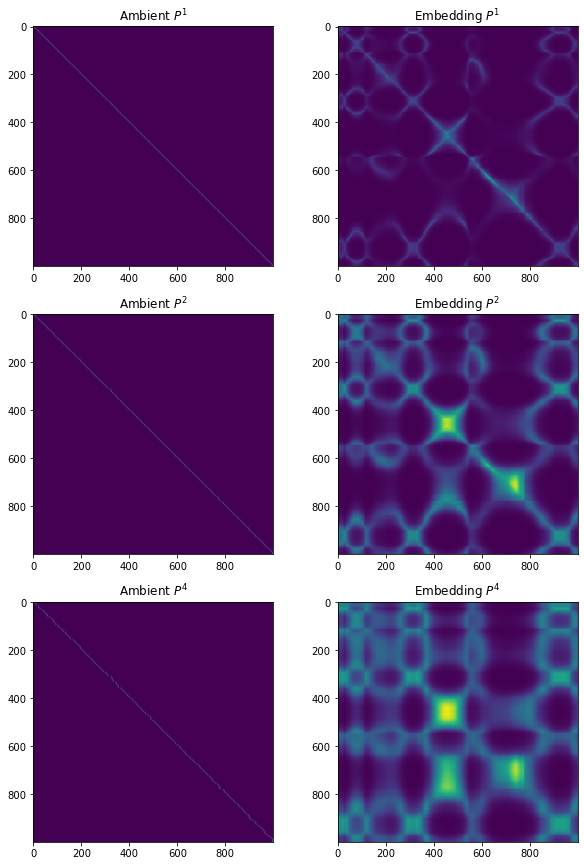

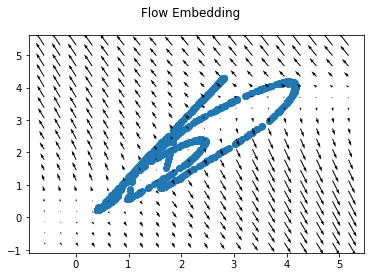

  2%|▏         | 200/10000 [00:30<26:09,  6.24it/s]  

EPOCH 200. Loss 8.326654434204102. Flow strength 4.955779552459717. Heatmap of P embedding is 


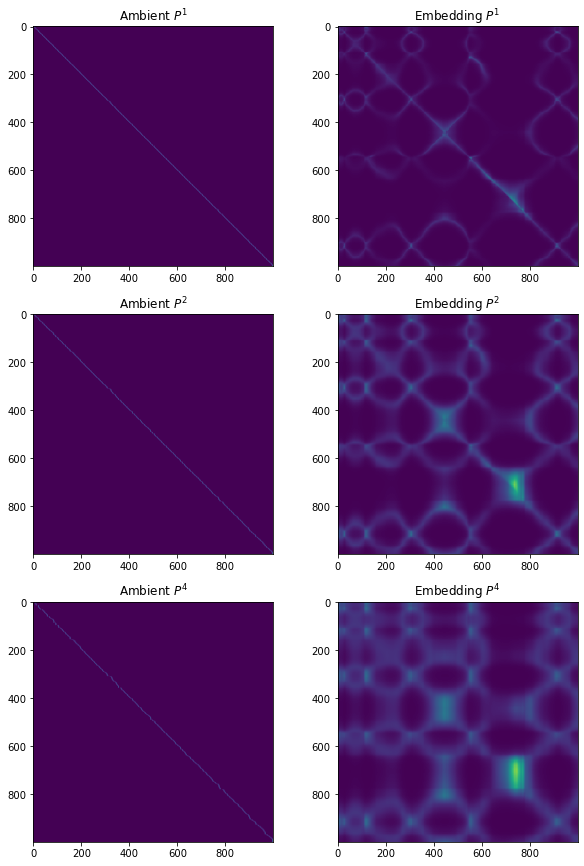

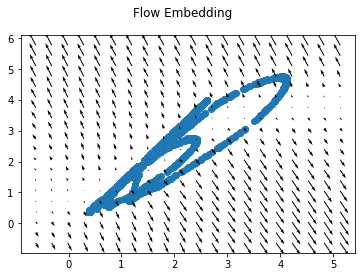

  3%|▎         | 300/10000 [00:44<22:10,  7.29it/s]  

EPOCH 300. Loss 8.010849952697754. Flow strength 4.956110954284668. Heatmap of P embedding is 


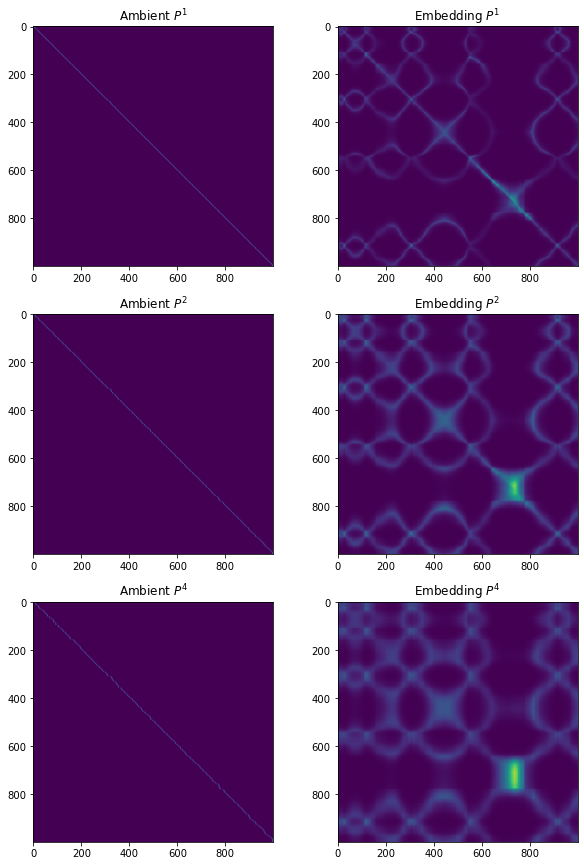

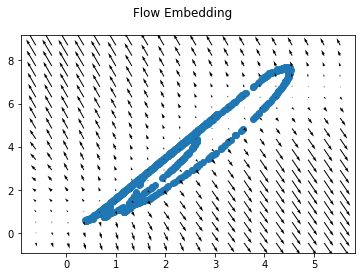

  4%|▍         | 400/10000 [00:59<22:36,  7.08it/s]  

EPOCH 400. Loss 7.801275730133057. Flow strength 4.9596638679504395. Heatmap of P embedding is 


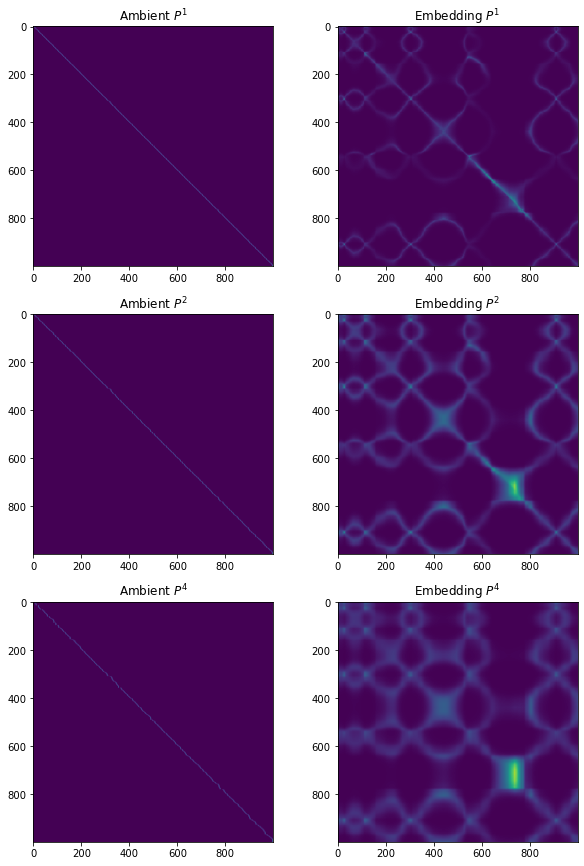

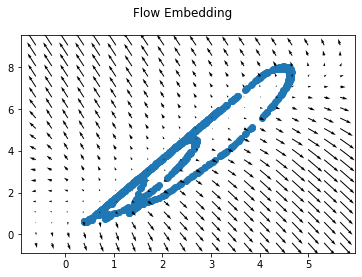

  5%|▌         | 500/10000 [01:14<21:53,  7.23it/s]  

EPOCH 500. Loss 7.280424118041992. Flow strength 4.979403018951416. Heatmap of P embedding is 


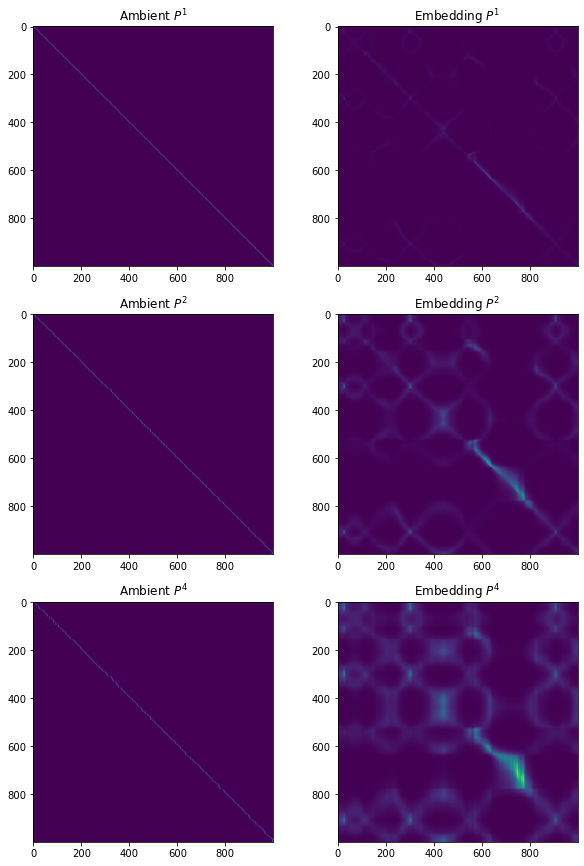

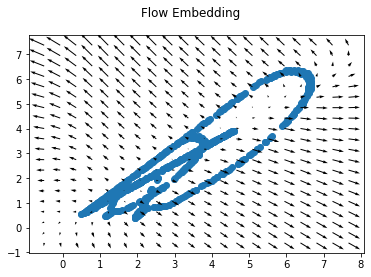

  6%|▌         | 600/10000 [01:29<22:26,  6.98it/s]  

EPOCH 600. Loss 6.438525199890137. Flow strength 4.982205867767334. Heatmap of P embedding is 


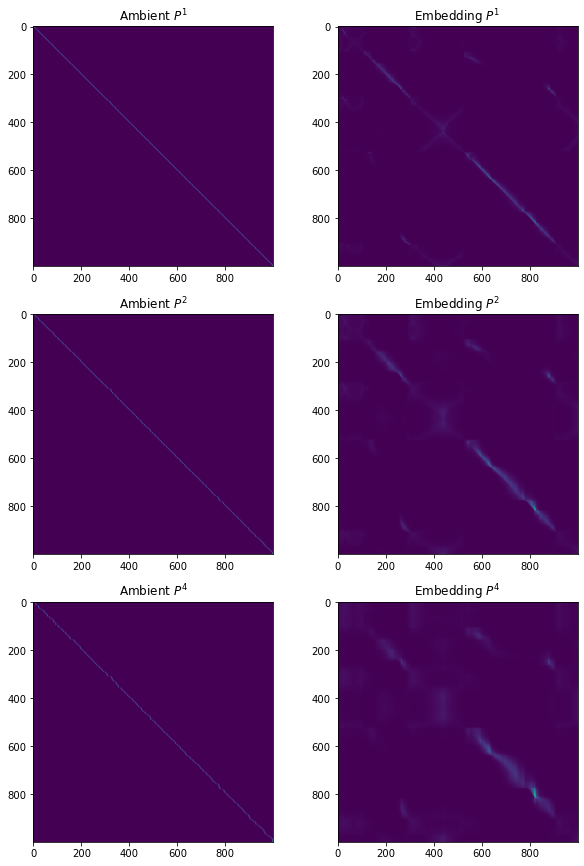

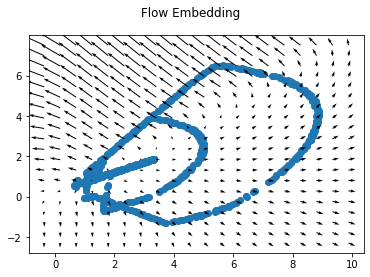

  7%|▋         | 700/10000 [01:44<23:43,  6.53it/s]  

EPOCH 700. Loss 6.5063371658325195. Flow strength 4.990403175354004. Heatmap of P embedding is 


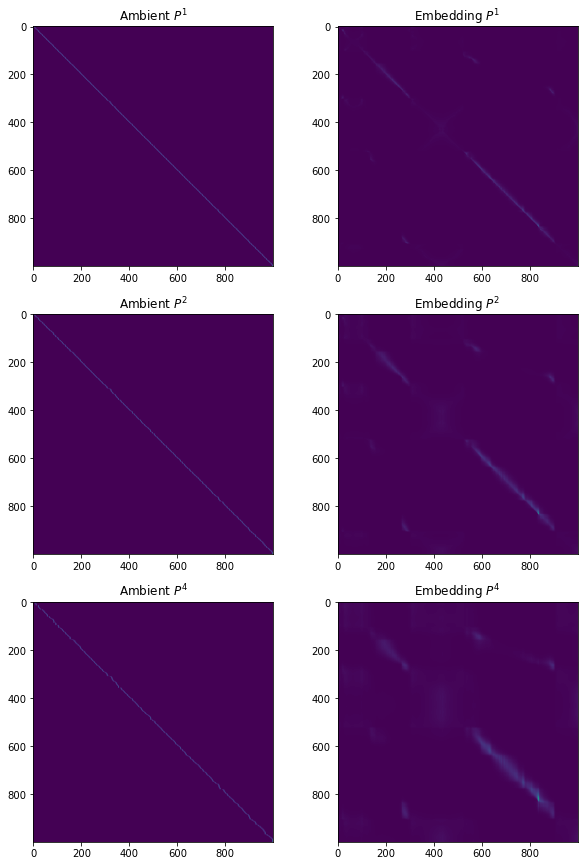

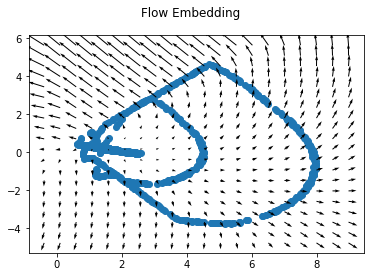

  8%|▊         | 800/10000 [01:58<17:17,  8.87it/s]  

EPOCH 800. Loss 6.906248092651367. Flow strength 4.994604110717773. Heatmap of P embedding is 


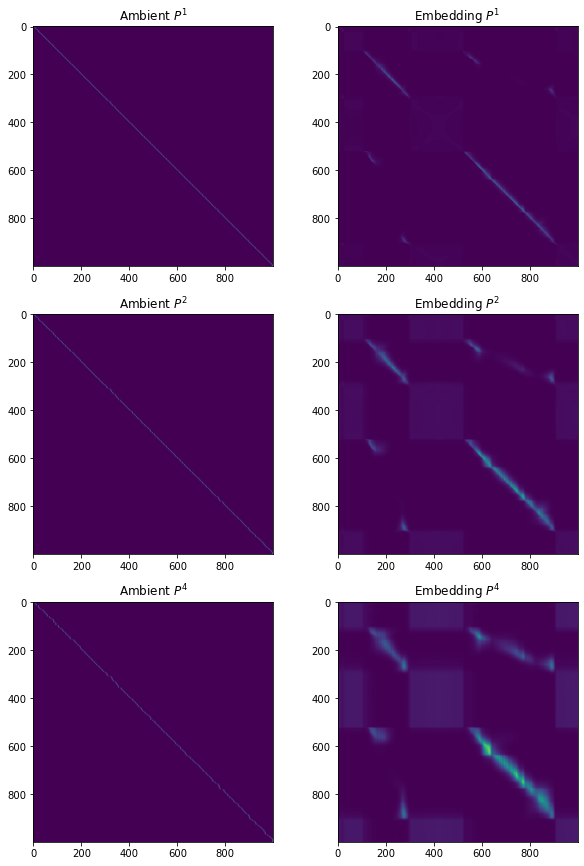

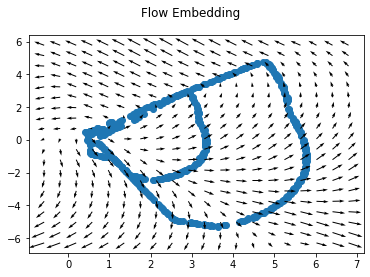

  9%|▉         | 900/10000 [02:12<24:16,  6.25it/s]  

EPOCH 900. Loss 6.449456214904785. Flow strength 4.994830131530762. Heatmap of P embedding is 


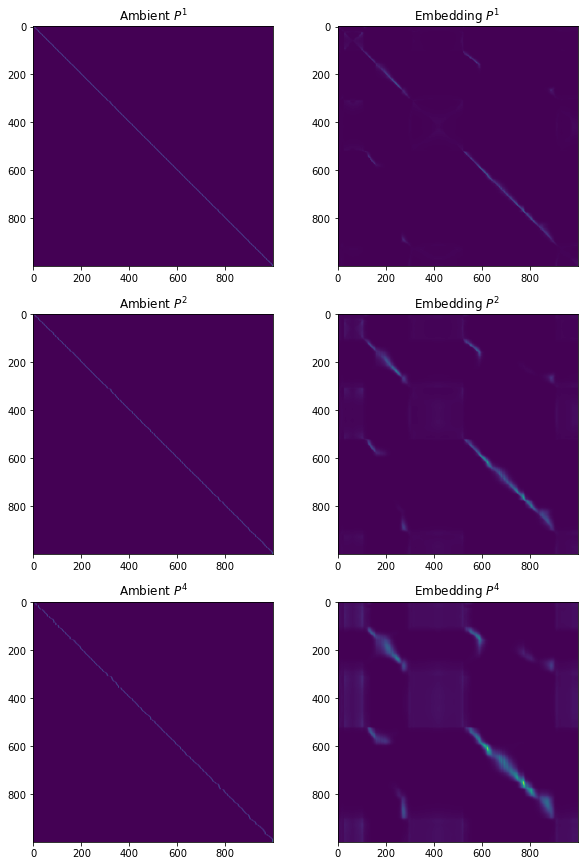

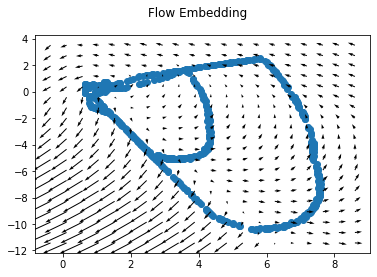

 10%|█         | 1000/10000 [02:26<20:38,  7.27it/s] 

EPOCH 1000. Loss 6.436872482299805. Flow strength 4.991913318634033. Heatmap of P embedding is 


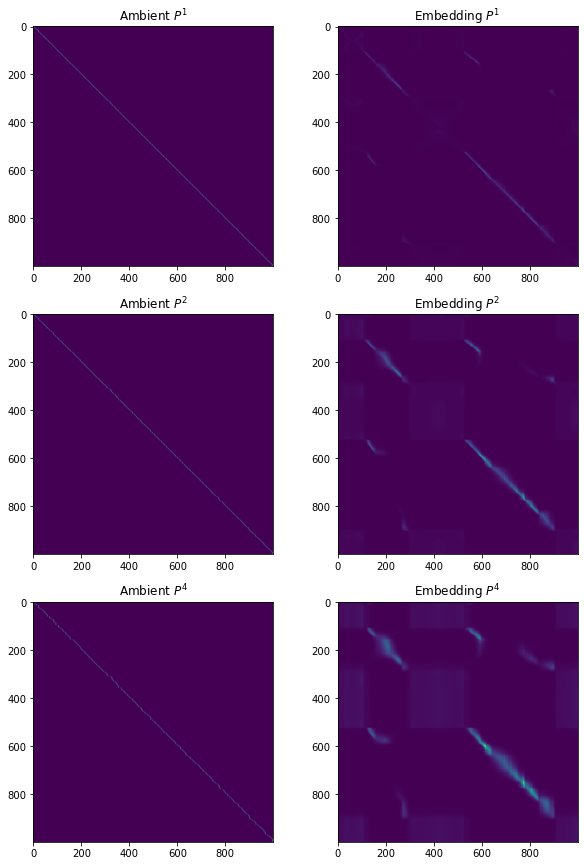

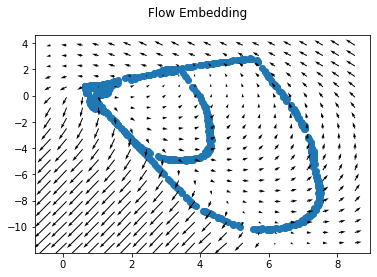

 11%|█         | 1100/10000 [02:39<16:41,  8.88it/s]  

EPOCH 1100. Loss 6.227049827575684. Flow strength 4.983253002166748. Heatmap of P embedding is 


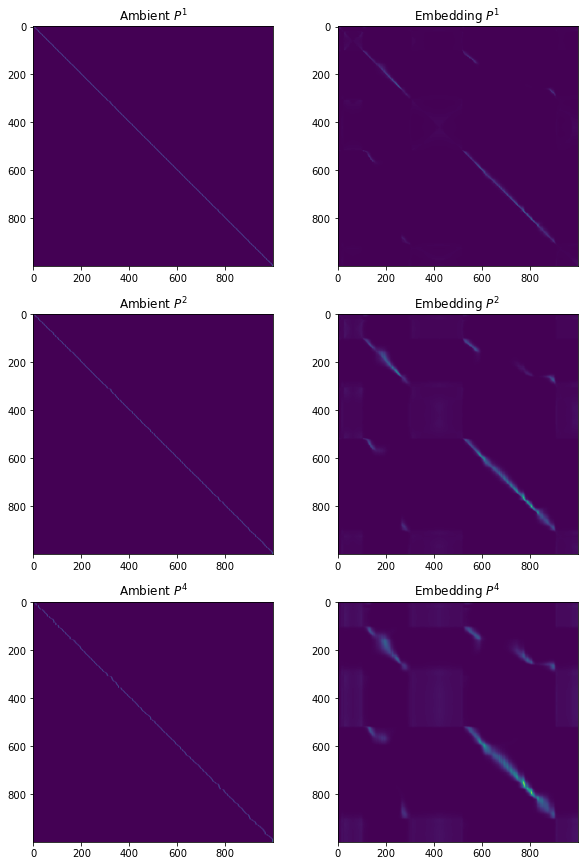

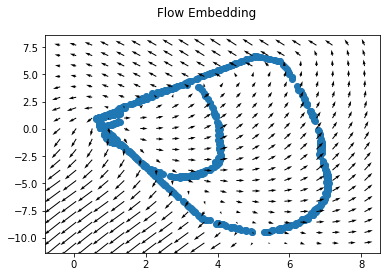

 12%|█▏        | 1200/10000 [02:51<20:18,  7.22it/s]  

EPOCH 1200. Loss 6.149223327636719. Flow strength 4.982929706573486. Heatmap of P embedding is 


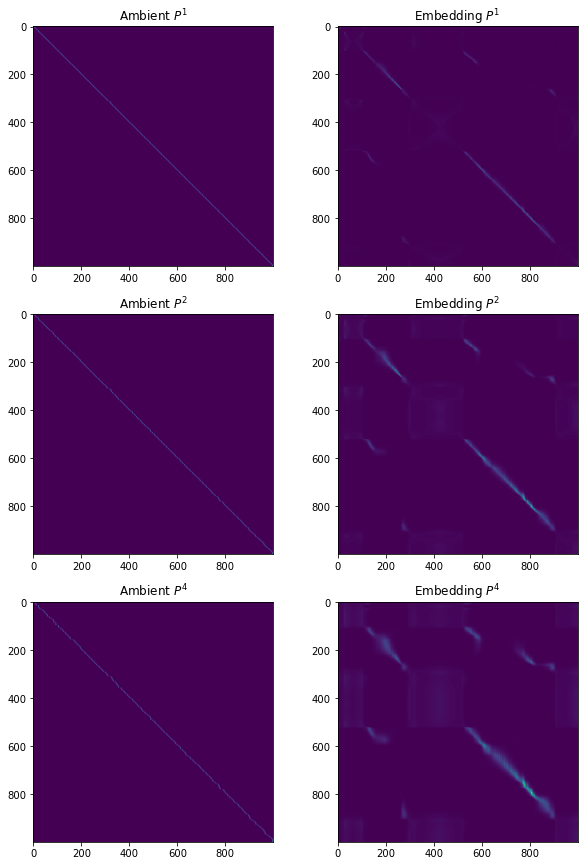

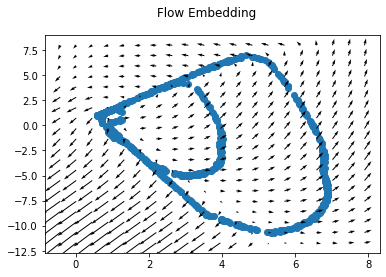

 13%|█▎        | 1300/10000 [03:06<19:53,  7.29it/s]  

EPOCH 1300. Loss 5.984847068786621. Flow strength 4.990385055541992. Heatmap of P embedding is 


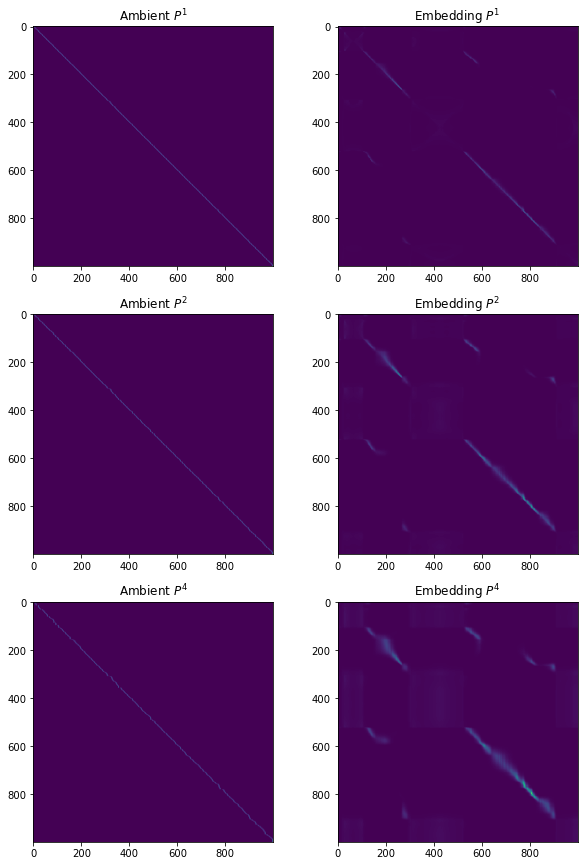

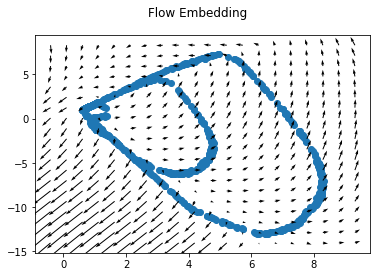

 14%|█▍        | 1400/10000 [03:20<19:42,  7.27it/s]  

EPOCH 1400. Loss 5.991268634796143. Flow strength 4.995453357696533. Heatmap of P embedding is 


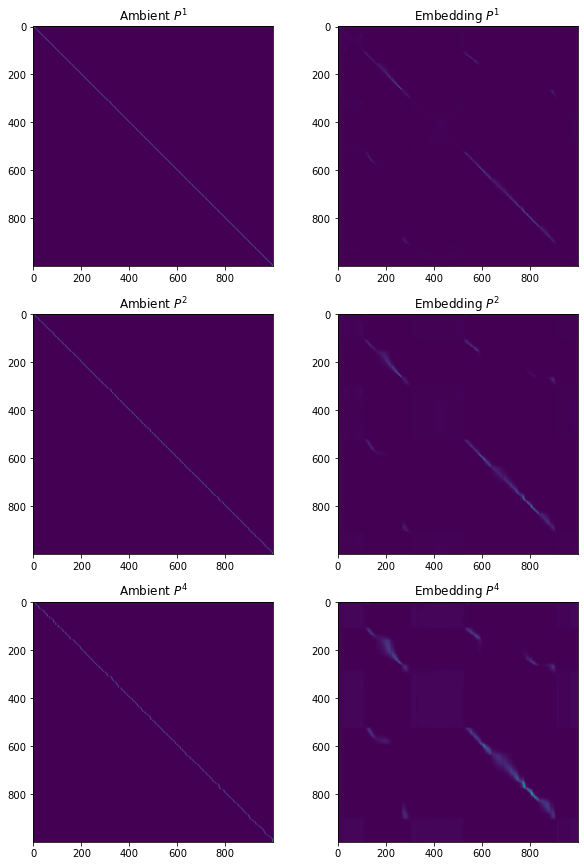

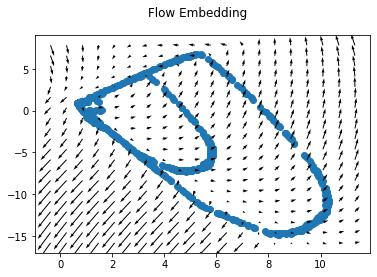

 15%|█▌        | 1500/10000 [03:35<19:28,  7.28it/s]

EPOCH 1500. Loss 5.852634906768799. Flow strength 5.002211093902588. Heatmap of P embedding is 


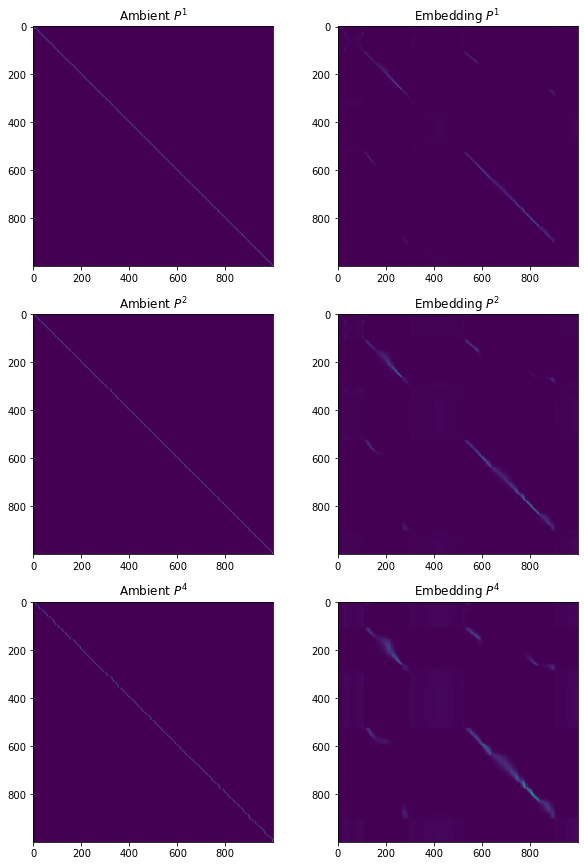

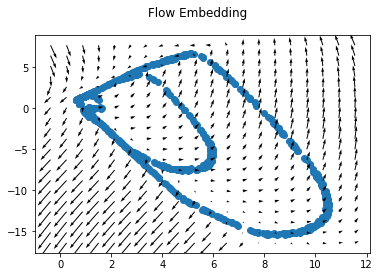

 16%|█▌        | 1600/10000 [03:50<19:15,  7.27it/s]

EPOCH 1600. Loss 5.773377895355225. Flow strength 5.013149738311768. Heatmap of P embedding is 


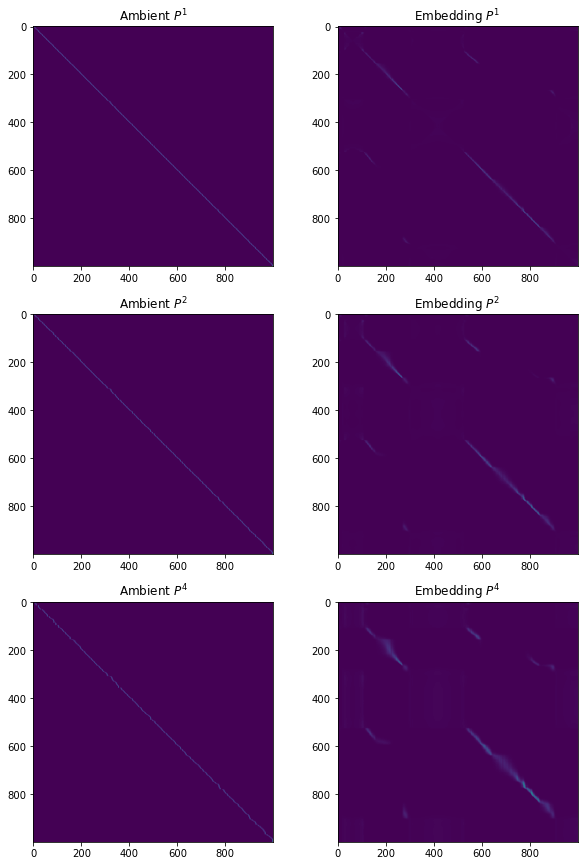

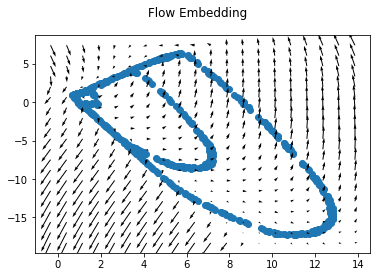

 17%|█▋        | 1700/10000 [04:04<18:34,  7.45it/s]  

EPOCH 1700. Loss 5.805696964263916. Flow strength 5.04870080947876. Heatmap of P embedding is 


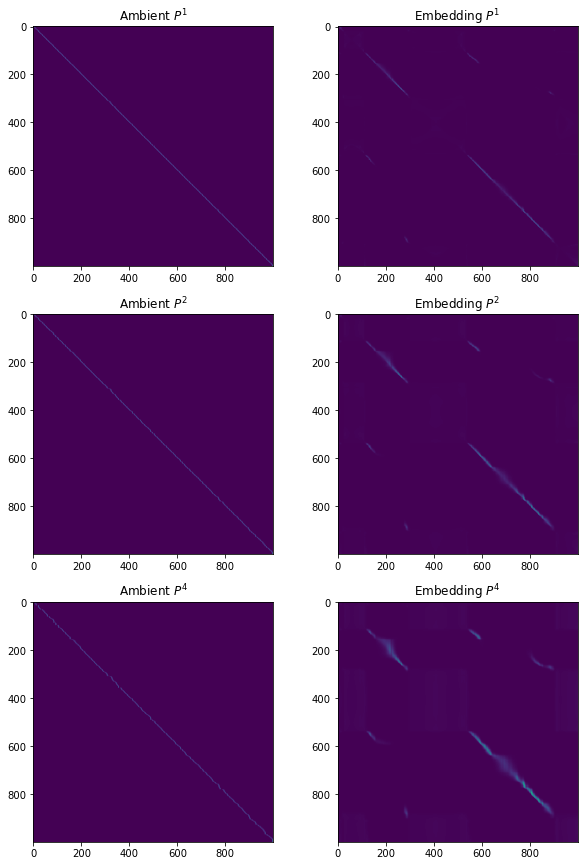

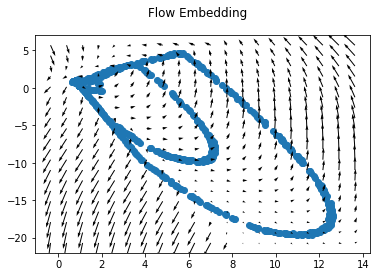

 18%|█▊        | 1800/10000 [04:19<19:17,  7.09it/s]

EPOCH 1800. Loss 5.712757110595703. Flow strength 5.038760662078857. Heatmap of P embedding is 


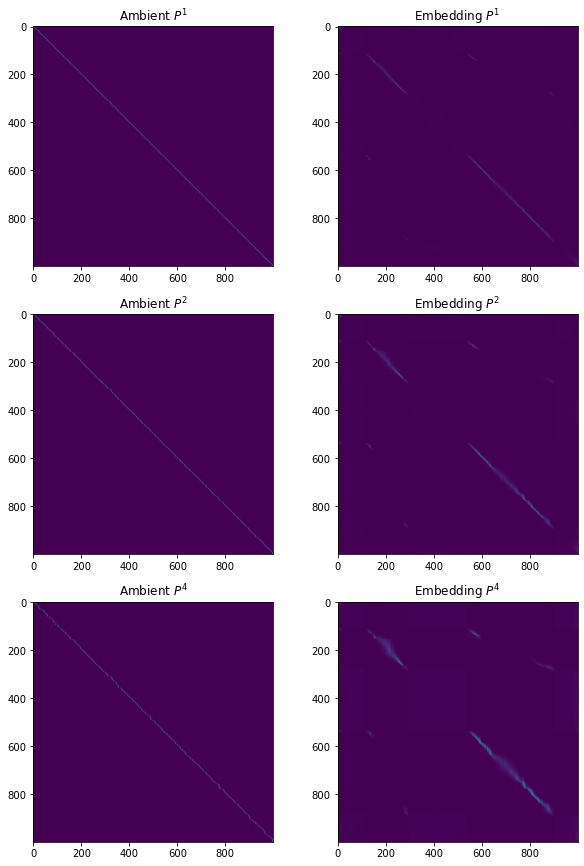

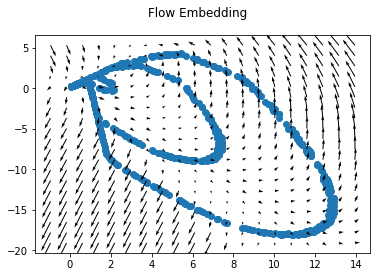

 19%|█▉        | 1900/10000 [04:33<18:37,  7.25it/s]

EPOCH 1900. Loss 5.071902751922607. Flow strength 5.019508361816406. Heatmap of P embedding is 


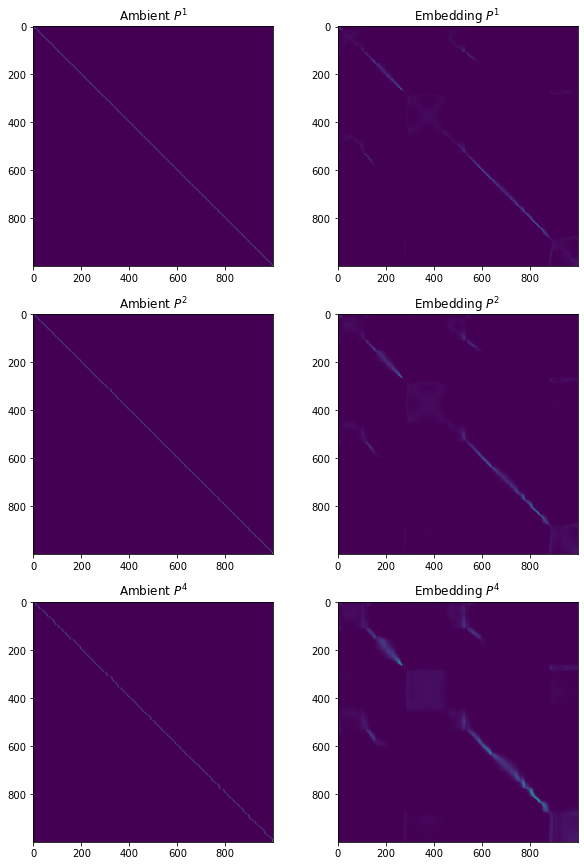

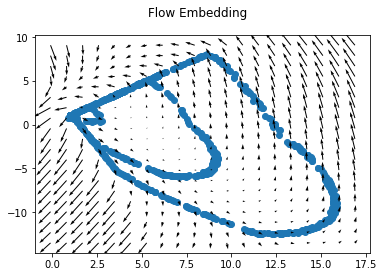

 20%|██        | 2000/10000 [04:47<17:01,  7.84it/s]

EPOCH 2000. Loss 4.494369983673096. Flow strength 5.034949779510498. Heatmap of P embedding is 


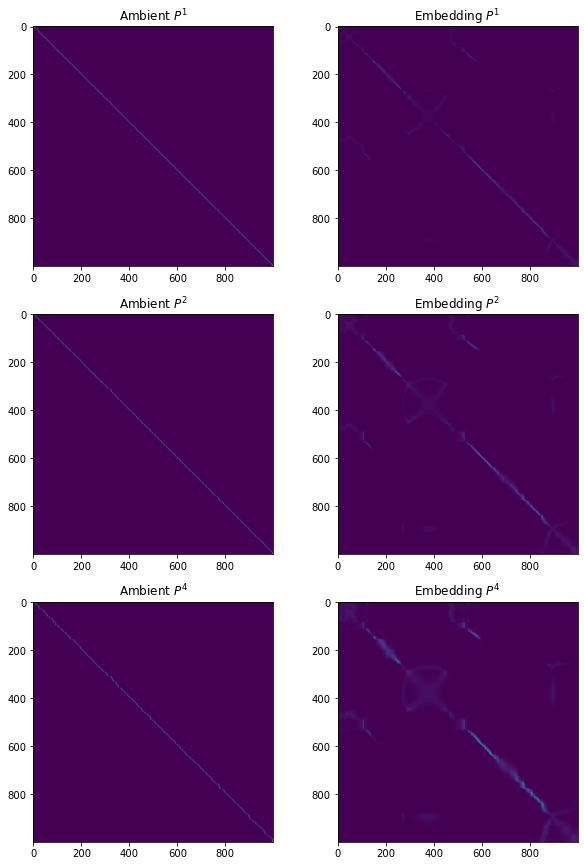

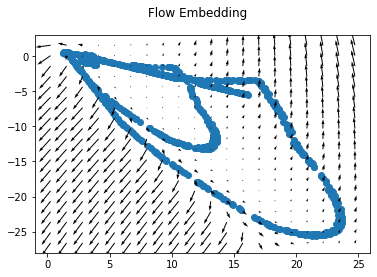

 21%|██        | 2100/10000 [05:01<21:47,  6.04it/s]

EPOCH 2100. Loss 3.9733169078826904. Flow strength 5.047738075256348. Heatmap of P embedding is 


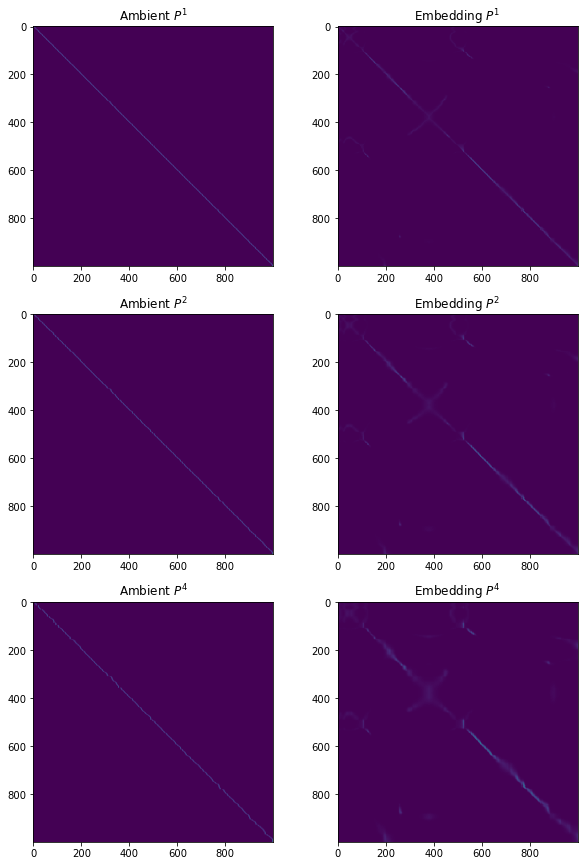

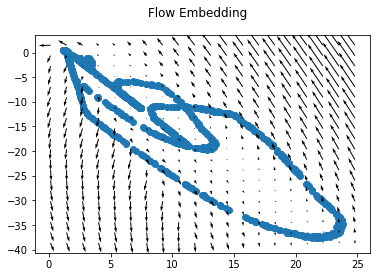

 21%|██        | 2122/10000 [05:06<18:22,  7.15it/s]  

In [ ]:
MFE.fit(n_steps=10000)

In [ ]:
!nbdev_build_lib

Converted 00_core.ipynb.
Converted 01a Graph Utils.ipynb.
Converted 01d Batch Testing Scripts.ipynb.
Converted 01e01 JSON Testing Script.ipynb.
Converted 02d01_Snake_TestCase.ipynb.
Converted 02d01a_Snake_With5b.ipynb.
Converted 02d02 Circles and Swiss roll Datasets.ipynb.
Converted 02d02a Testing Diffusion Flow Embedder on Circle and Swiss Roll.ipynb.
Converted 02d03 Spheres and Donuts with Flow (datasets).ipynb.
Converted 02d04 Tree and Flow Artist Test.ipynb.
Converted 02d05 Branch and Clusters.ipynb.
Converted 02d05a Testing Branch Clusters Circle Swiss roll.ipynb.
Converted 04a UW on RNA Data.ipynb.
Converted 05b Flow Embedding with Diffusion.ipynb.
Converted 05b01 Testing diffusion flow embedder.ipynb.
Converted 05b01a Diffusion Flow Embedding on Pancreas_RNA_Velocity.ipynb.
Converted 05b01a01 RNA Velocity Analysis.ipynb.
Converted 05b01a02 rna-velo_viz_phate.ipynb.
Converted 05b01a03 More_RNA_Velocity_Datasets.ipynb.
Converted 05b02 Flow-Artist_Upgrade.ipynb.
Converted 05b03 Flo

# Test: 2D Sinusoidal Ribbon

# Test: 3D Sinusoidal Ribbon

In [ ]:
from directed_graphs.datasets import plot_ribbon, sample_ribbon, plot_ribbon_samples
from directed_graphs.datasets import affinity_grid_search

: 

: 

In [ ]:
plot_ribbon()
X, X_ = sample_ribbon()
labels = X
plot_ribbon_samples(X, X_)

In [ ]:
X = torch.tensor(X)
X_ = torch.tensor(X_)
X = X.float().to(device)
X_ = X_.float().to(device)

In [ ]:
affinity_grid_search(X, X_, sigmas=[0.5, 1, 3, 5], flow_strengths=[1, 2, 5, 10])

In [ ]:
dfe = DiffusionFlowEmbedder(
    X,
    X_,
    t=1,
    sigma_graph=15,
    sigma_embedding=15,
    device=device,
    autoencoder_shape=[50, 10],
    flow_artist_shape=[30, 20, 10],
    flow_strength_graph=2,
    flow_strength_embedding=5,
    learnable_flow_strength=True,
    weight_of_flow=0.5,
    learning_rate=0.001,
)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)

In [ ]:
dfe.visualize_points(labels)